# Comprehensive Constraints Analysis - Final

In this notebook, for the original dataset, the violations are determined in total.

In [1]:
import gzip
from tqdm.notebook import tqdm
propFileDict = {}
fileLineCount = 1149471184
with gzip.open('../../gdrive-kgtk-dump-2020-12-07/claims.tsv.gz','r') as fin: 
    headerLine = next(fin).decode("utf-8")
#     tstCount = 0
    for line in tqdm(fin, total = fileLineCount):
        line = line.decode("utf-8")
        lineP = line.rstrip().split("\t")
        if "external-id" in lineP[-1]:
            continue
        prop = lineP[2]
        if prop not in propFileDict:
            propFileDict[prop] = open("../../propertiesSplit_Final/claims."+str(prop)+".tsv","w")
            propFileDict[prop].write(headerLine)
        propFileDict[prop].write(line)
#         tstCount += 1
#         if tstCount == 10:
#             break
    for file1 in propFileDict.values():
        file1.close()

  0%|          | 0/1149471184 [00:00<?, ?it/s]

# Generate Queries

## Type Constraint

Type constraint indicates that node1 must be an instance of or subclass of the class specified.

### Understand Constraints File

In [2]:
!kgtk --debug query -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz \
    ../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz \
    --match "p: (nodeProp1)-[nodePropEdge:P2302]->(nodeabc{wikidatatype:wikidatatype}), q: (nodePropEdge1)-[nodePropEdgeProps]->(val)" \
    --where 'nodePropEdge.id = nodePropEdge1 and nodeabc = "Q21503250"' \
    --return 'nodePropEdge.id as id, nodeProp1 as node1, nodePropEdgeProps.label as label, val as node2, wikidatatype as `node2;wikidatatype`' \
    -o ../../constraintsOP/typeConstraint/claims.type-constraints_all.tsv \
    --graph-cache ../../sqlite3_caches/temp156.sqlite3.db

[2021-05-10 20:16:55 sqlstore]: IMPORT graph directly into table graph_1 from /data/wd-correctness/gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz ...
[2021-05-10 20:16:55 sqlstore]: IMPORT graph directly into table graph_2 from /data/wd-correctness/gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz ...
[2021-05-10 20:16:56 query]: SQL Translation:
---------------------------------------------
  SELECT graph_1_c1."id" "_aLias.id", graph_1_c1."node1" "_aLias.node1", graph_2_c2."label" "_aLias.label", graph_2_c2."node2" "_aLias.node2", graph_1_c1."node2;wikidatatype" "_aLias.node2;wikidatatype"
     FROM graph_1 AS graph_1_c1, graph_2 AS graph_2_c2
     WHERE graph_1_c1."label"=?
     AND graph_1_c1."node2;wikidatatype"=graph_1_c1."node2;wikidatatype"
     AND ((graph_1_c1."id" = graph_2_c2."node1") AND (graph_1_c1."node2" = ?))
  PARAS: ['P2302', 'Q21503250']
---------------------------------------------
[2021-05-10 20:16:56 sqlstore]: CREATE INDEX on table graph_1 column lab

In [7]:
import pandas as pd
df = pd.read_csv('../../constraintsOP/typeConstraint/claims.type-constraints_all.tsv',sep='\t')

In [8]:
df1 = df.groupby(['node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [9]:
df1.head()

,node1,label,node2
0,P1001,P2308,"[Q102496, Q105985, Q1140371, Q1151067, Q119768..."
1,P1001,P2309,[Q30208840]
2,P1002,P2308,[Q630010]
3,P1002,P2309,[Q21514624]
4,P1004,P2308,"[Q2221906, Q23413, Q3947, Q41176, Q88291]"


In [10]:
df1[df1['node1'] == 'P8138']

,node1,label,node2
9318,P8138,P2308,[Q27096213]
9319,P8138,P2309,[Q21514624]


### Query Generator

In [14]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 1

fOP = None

for prop in tqdm(df1.node1.unique()):
    try:
        if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop +".tsv")):
            continue
        relation = df1[(df1['node1'] == prop) & (df1['label'] == 'P2309')].node2.values[0][0]
        type1 = df1[(df1['node1'] == prop) & (df1['label'] == 'P2316')].node2.values
#         print(type1)

        parents = df1[(df1['node1'] == prop) & (df1['label'] == 'P2308')].node2.values[0]
        exceptions = df1[(df1['node1'] == prop) & (df1['label'] == 'P2303')].node2.values
        
        if relation == "Q21503252":
            parentFile = "P31"
            parentTitle = 'instanceOf'
        elif relation == "Q21514624":
            parentFile = "P279"
            parentTitle = 'subclass'
        else:
            parentFile = "isa"
            parentTitle = 'instanceOfOrSubclass'

        if len(type1) != 0 and type1[0][0] == "Q21502408":
            typeVal = "mandatory"
        elif len(type1) != 0 and type1[0][0] == "Q62026391":
            typeVal = "suggestion"
        else:
            typeVal = "normal"

        if len(exceptions):
            exceptionPart = "or node1 in " + str(exceptions[0]).replace("'",'"')
        else:
            exceptionPart = ""
        
        folderName = 'typeConstraint'
        shellFileSuffix = 'typeConstraintValidator'
        
        if cnt % 150 == 0:
            if fOP:
                fOP.close()
            fOP = open("../../propertiesSplit_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
            fCnt += 1
        
        fOP.write("{ time (kgtk --debug query -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
        ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
        ../../wikidata-20210215/derived.P279star.tsv.gz \
        --match 'm: (node1)-[nodeProp]->(node2), " + parentFile + ": (node1)-[]->(nodex), P279star: (nodex)-[]->(par)' \
        --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
        --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`' \
        -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        --graph-cache ../../sqlite3_caches/type_new_" + str(fCnt) + ".sqlite3.db; \
         kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
        --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv ;\
        kgtk --debug query -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv \
        ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
        --match 'm: (node1)-[nodeProp]->(node2), " + parentFile + ": (node1)-[]->(par)' \
        --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
        --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`' \
        -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        --graph-cache ../../sqlite3_caches/type_new_" + str(fCnt) + ".sqlite3.db; \
         kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv \
        --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect.tsv ; \
         kgtk --debug cat -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct.tsv ; \
        ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n")

        cnt += 1
    except:
        print("Something failed for prop:",prop)

if fOP:
    fOP.close()

  0%|          | 0/4810 [00:00<?, ?it/s]

Something failed for prop: P1249
Something failed for prop: P6790


In [15]:
cnt

1456

In [16]:
# import os
# for i in range(1,14):
#     os.system("screen -dm sh ../../propertiesSplit_Final/checkViolations/typeConstraintValidator"+str(i)+".sh")
    

### Analyze Violations

In [2]:
import pandas as pd
import os
from tqdm.notebook import tqdm

typeConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt

propList = set()

violations = {}

for folder in tqdm(iter(['mandatory', 'suggestion', 'normal'])):
    typeConstViolations[folder] = {'instanceOf': {'correct': 0, 'incorrect': 0}, 'subclass': {'correct': 0, 'incorrect': 0}, 'instanceOfOrSubclass': {'correct': 0, 'incorrect': 0},'propCount': 0}
    filePath = "../../allConstraintsAnalysis_Final/typeConstraint/"+folder+"/"
    for filename in tqdm(os.listdir(filePath)):
        type1 = filename.split(".")[2]
        prop = filename.split(".")[3]
        propList.add(prop)
        correctness = filename.split(".")[4]
        count1 = countLines(filePath+filename)
        if correctness not in ['correct','incorrect']:
            continue
        typeConstViolations[folder][type1][correctness] += count1
        if prop not in violations:
            violations[prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        violations[prop][correctness] = count1
        violations[prop]['paths'].append(filePath+filename)
        if correctness == 'correct':
            typeConstViolations[folder]['propCount'] += 1
        

0it [00:00, ?it/s]

  0%|          | 0/825 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6400 [00:00<?, ?it/s]

In [3]:
recordCount = 0
for elem in typeConstViolations.keys():
    for key1 in typeConstViolations[elem].keys():
        try:
            recordCount += typeConstViolations[elem][key1]['correct'] + typeConstViolations[elem][key1]['incorrect']
        except:
            continue
print(f"{len(propList)} properties processed for type constraint for {recordCount} statements")

1456 properties processed for type constraint for 513424170 statements


In [4]:
import pandas as pd
typeConstDF = pd.DataFrame(violations).T

In [5]:
typeConstDF['violation_ratio'] = typeConstDF.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)

In [6]:
typeConstDF.head()

,correct,incorrect,paths,violation_ratio
P8379,29,3,[../../allConstraintsAnalysis_Final/typeConstr...,0.093750
P5105,1919,95,[../../allConstraintsAnalysis_Final/typeConstr...,0.047170
P720,403,0,[../../allConstraintsAnalysis_Final/typeConstr...,0.000000
P3022,3743,0,[../../allConstraintsAnalysis_Final/typeConstr...,0.000000
P512,101717,95,[../../allConstraintsAnalysis_Final/typeConstr...,0.000933


In [7]:
typeConstDF.sort_values(by=['violation_ratio','incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P8138,0,461,[../../allConstraintsAnalysis_Final/typeConstr...,1.0
P5051,0,64,[../../allConstraintsAnalysis_Final/typeConstr...,1.0
P2303,0,39,[../../allConstraintsAnalysis_Final/typeConstr...,1.0
P1227,0,19,[../../allConstraintsAnalysis_Final/typeConstr...,1.0
P2308,0,17,[../../allConstraintsAnalysis_Final/typeConstr...,1.0
P6001,0,16,[../../allConstraintsAnalysis_Final/typeConstr...,1.0
P8738,0,14,[../../allConstraintsAnalysis_Final/typeConstr...,1.0
P538,0,10,[../../allConstraintsAnalysis_Final/typeConstr...,1.0
P8004,0,6,[../../allConstraintsAnalysis_Final/typeConstr...,1.0
P5589,0,4,[../../allConstraintsAnalysis_Final/typeConstr...,1.0


In [8]:
typeConstDF['violation_ratio'].describe()

count    1456.000000
mean        0.100094
std         0.222405
min         0.000000
25%         0.000708
50%         0.009036
75%         0.061943
max         1.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Type Constraint Violation Ratios')

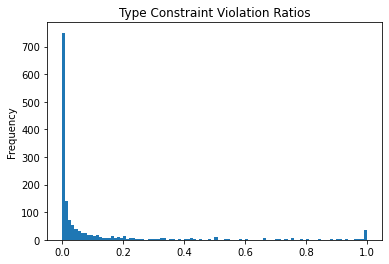

In [9]:
typeConstDF['violation_ratio'].plot.hist(bins=100).set_title("Type Constraint Violation Ratios")

Text(0.5, 1.0, 'Type Constraint Violation Ratios (<=0.05)')

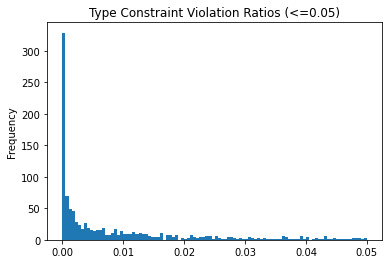

In [10]:
typeConstDF[typeConstDF['violation_ratio'] <= 0.05].violation_ratio.plot.hist(bins=100).set_title("Type Constraint Violation Ratios (<=0.05)")

In [11]:
print(f"No. of constraints whose violation ratio is greater than mean :{sum(typeConstDF['violation_ratio'] >= 5.286054)}/{len(typeConstDF)}")

No. of constraints whose violation ratio is greater than mean :0/1456


In [12]:
for key1 in typeConstViolations.keys():
    typeConstViolations[key1]['correct'] = typeConstViolations[key1]['instanceOf']['correct'] + typeConstViolations[key1]['subclass']['correct'] + typeConstViolations[key1]['instanceOfOrSubclass']['correct']
    typeConstViolations[key1]['incorrect'] = typeConstViolations[key1]['instanceOf']['incorrect'] + typeConstViolations[key1]['subclass']['incorrect'] + typeConstViolations[key1]['instanceOfOrSubclass']['incorrect']
    typeConstViolations[key1]['VR'] = typeConstViolations[key1]['incorrect'] / (typeConstViolations[key1]['correct'] + typeConstViolations[key1]['incorrect'])
        

In [13]:
typeConstViolations

{'mandatory': {'instanceOf': {'correct': 44771087, 'incorrect': 37435},
  'subclass': {'correct': 1966, 'incorrect': 30},
  'instanceOfOrSubclass': {'correct': 221394, 'incorrect': 204},
  'propCount': 165,
  'correct': 44994447,
  'incorrect': 37669,
  'VR': 0.0008364918939185536},
 'suggestion': {'instanceOf': {'correct': 61720, 'incorrect': 18709},
  'subclass': {'correct': 0, 'incorrect': 0},
  'instanceOfOrSubclass': {'correct': 23314, 'incorrect': 2939},
  'propCount': 11,
  'correct': 85034,
  'incorrect': 21648,
  'VR': 0.20292083013066872},
 'normal': {'instanceOf': {'correct': 398242129, 'incorrect': 3281243},
  'subclass': {'correct': 96605, 'incorrect': 9501},
  'instanceOfOrSubclass': {'correct': 66370309, 'incorrect': 285585},
  'propCount': 1280,
  'correct': 464709043,
  'incorrect': 3576329,
  'VR': 0.007637071781093346}}

In [14]:
typeConstDF['total'] = typeConstDF['correct'] + typeConstDF['incorrect']
typeConstDF.sort_values(by=['total'],ascending=False).head()

,correct,incorrect,paths,violation_ratio,total
P2093,134805165,543246,[../../allConstraintsAnalysis_Final/typeConstr...,0.004014,135348411
P1476,39898142,1858292,[../../allConstraintsAnalysis_Final/typeConstr...,0.044503,41756434
P577,38855314,33977,[../../allConstraintsAnalysis_Final/typeConstr...,0.000874,38889291
P1433,36723283,12050,[../../allConstraintsAnalysis_Final/typeConstr...,0.000328,36735333
P1215,33099195,24104,[../../allConstraintsAnalysis_Final/typeConstr...,0.000728,33123299


In [15]:
typeConstDF.to_csv('../../allConstraintsAnalysis_Final/typeConstDFAnalysis.csv')

### Find out time required

In [124]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
filePath = '/data/wd-correctness/propertiesSplit_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("typeConstraintValidator"):
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes

  0%|          | 0/52 [00:00<?, ?it/s]

In [125]:
print(pd.Series(times).describe())

count    1456.000000
mean      366.161277
std       486.075212
min         4.953000
25%       102.821500
50%       174.777000
75%       455.812750
max      5231.151000
dtype: float64


Text(0.5, 1.0, 'Distribution of times (in s) taken for type constraint checks')

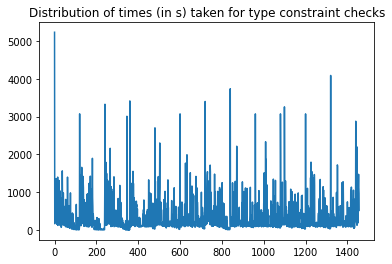

In [126]:
import seaborn as sns
sns.lineplot(data=pd.Series(times)).set_title("Distribution of times (in s) taken for type constraint checks")

## Value Type Constraint

Here, the constraint indicates that node2 must be an instance of or subclass of the specified class

### Understand Constraints File

In [17]:
!kgtk --debug query -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz \
    ../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz \
    --match "p: (nodeProp1)-[nodePropEdge:P2302]->(nodeabc{wikidatatype:wikidatatype}), q: (nodePropEdge1)-[nodePropEdgeProps]->(val)" \
    --where 'nodePropEdge.id = nodePropEdge1 and nodeabc = "Q21510865"' \
    --return 'nodePropEdge.id as id, nodeProp1 as node1, nodePropEdgeProps.label as label, val as node2, wikidatatype as `node2;wikidatatype`' \
    -o ../../constraintsOP/valuetypeConstraint/claims.type-constraints_all1.tsv \
    --graph-cache ../../sqlite3_caches/temp1345.valuetype.sqlite3.db

[2021-05-10 20:31:12 sqlstore]: IMPORT graph directly into table graph_1 from /data/wd-correctness/gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz ...
[2021-05-10 20:31:14 sqlstore]: IMPORT graph directly into table graph_2 from /data/wd-correctness/gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz ...
[2021-05-10 20:31:15 query]: SQL Translation:
---------------------------------------------
  SELECT graph_1_c1."id" "_aLias.id", graph_1_c1."node1" "_aLias.node1", graph_2_c2."label" "_aLias.label", graph_2_c2."node2" "_aLias.node2", graph_1_c1."node2;wikidatatype" "_aLias.node2;wikidatatype"
     FROM graph_1 AS graph_1_c1, graph_2 AS graph_2_c2
     WHERE graph_1_c1."label"=?
     AND graph_1_c1."node2;wikidatatype"=graph_1_c1."node2;wikidatatype"
     AND ((graph_1_c1."id" = graph_2_c2."node1") AND (graph_1_c1."node2" = ?))
  PARAS: ['P2302', 'Q21510865']
---------------------------------------------
[2021-05-10 20:31:15 sqlstore]: CREATE INDEX on table graph_1 column lab

In [18]:
import pandas as pd
dfValueType = pd.read_csv('../../constraintsOP/valuetypeConstraint/claims.type-constraints_all1.tsv',sep='\t')

In [19]:
dfValueType = dfValueType.groupby(['node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [20]:
dfValueType.head()

,node1,label,node2
0,P1000,P2308,[Q1241356]
1,P1000,P2309,[Q30208840]
2,P1001,P2308,"[Q20926517, Q2881272, Q2882257, Q3624078, Q389..."
3,P1001,P2309,[Q30208840]
4,P1002,P2308,[Q2576663]


In [21]:
dfValueType['label'].unique()

array(['P2308', 'P2309', 'P2303', 'P2316', 'P6607', 'P2304'], dtype=object)

### Query Generator

In [55]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 1

fOP = None

for prop in tqdm(dfValueType.node1.unique()):
    try:
        if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop +".tsv")):
            continue
        relation = dfValueType[(dfValueType['node1'] == prop) & (dfValueType['label'] == 'P2309')].node2.values[0][0]
        type1 = dfValueType[(dfValueType['node1'] == prop) & (dfValueType['label'] == 'P2316')].node2.values
#         print(type1)

        parents = dfValueType[(dfValueType['node1'] == prop) & (dfValueType['label'] == 'P2308')].node2.values[0]
        exceptions = dfValueType[(dfValueType['node1'] == prop) & (dfValueType['label'] == 'P2303')].node2.values
        
        if relation == "Q21503252":
            parentFile = "P31"
            parentTitle = 'instanceOf'
        elif relation == "Q21514624":
            parentFile = "P279"
            parentTitle = 'subclass'
        else:
            parentFile = "isa"
            parentTitle = 'instanceOfOrSubclass'

        if len(type1) != 0 and type1[0][0] == "Q21502408":
            typeVal = "mandatory"
        elif len(type1) != 0 and type1[0][0] == "Q62026391":
            typeVal = "suggestion"
        else:
            typeVal = "normal"

        if len(exceptions):
            exceptionPart = "or node2 in " + str(exceptions[0]).replace("'",'"')
        else:
            exceptionPart = ""
        
        folderName = 'valueTypeConstraint'
        shellFileSuffix = 'valueTypeConstraintValidator'
        
        if cnt % 120 == 0:
            if fOP:
                fOP.close()
            fOP = open("../../propertiesSplit_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
            fCnt += 1
        
        fOP.write("{ time (kgtk --debug query -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
        ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
        ../../wikidata-20210215/derived.P279star.tsv.gz \
        --match 'm: (node1)-[nodeProp]->(node2), " + parentFile + ": (node2)-[]->(nodex), P279star: (nodex)-[]->(par)' \
        --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
        --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`' \
        -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        --graph-cache ../../sqlite3_caches/valueType_new_" + str(fCnt) + ".sqlite3.db; \
         kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
        --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv ;\
        kgtk --debug query -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv \
        ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
        --match 'm: (node1)-[nodeProp]->(node2), " + parentFile + ": (node2)-[]->(par)' \
        --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
        --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`' \
        -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        --graph-cache ../../sqlite3_caches/valueType_new_" + str(fCnt) + ".sqlite3.db; \
         kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv \
        --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect.tsv ; \
         kgtk --debug cat -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct.tsv ; \
        ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n")

        cnt += 1
    except:
        print("Something failed for prop:",prop)

if fOP:
    fOP.close()

  0%|          | 0/932 [00:00<?, ?it/s]

Something failed for prop: P1389


In [56]:
cnt

897

In [85]:
# import os
# for i in range(1,9):
#     os.system("screen -dm sh ../../propertiesSplit_Final/checkViolations/valueTypeConstraintValidator"+str(i)+".sh")
    

### Analyze Violations

In [16]:
import pandas as pd
import os
from tqdm.notebook import tqdm

valueTypeConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt

valueTypePropList = set()

violations = {}

for folder in tqdm(iter(['mandatory', 'suggestion', 'normal'])):
    valueTypeConstViolations[folder] = {'instanceOf': {'correct': 0, 'incorrect': 0}, 'subclass': {'correct': 0, 'incorrect': 0}, 'instanceOfOrSubclass': {'correct': 0, 'incorrect': 0}, 'propCount':0}
    filePath = "../../allConstraintsAnalysis_Final/valueTypeConstraint/"+folder+"/"
    for filename in tqdm(os.listdir(filePath)):
        type1 = filename.split(".")[2]
        prop = filename.split(".")[3]
        valueTypePropList.add(prop)
        correctness = filename.split(".")[4]
        count1 = countLines(filePath+filename)
        if correctness not in ['correct','incorrect']:
            continue
        valueTypeConstViolations[folder][type1][correctness] += count1
        if prop not in violations:
            violations[prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        violations[prop][correctness] = count1
        violations[prop]['paths'].append(filePath+filename)
        if correctness == 'correct':
            valueTypeConstViolations[folder]['propCount'] += 1
        

0it [00:00, ?it/s]

  0%|          | 0/530 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3930 [00:00<?, ?it/s]

In [17]:
recordCount = 0
for elem in valueTypeConstViolations.keys():
    for key1 in valueTypeConstViolations[elem].keys():
        try:
            recordCount += valueTypeConstViolations[elem][key1]['correct'] + valueTypeConstViolations[elem][key1]['incorrect']
        except:
            continue
print(f"{len(valueTypePropList)} properties processed for value type constraint for {recordCount} statements")

897 properties processed for value type constraint for 182087480 statements


In [18]:
import pandas as pd
valTypeConstDF = pd.DataFrame(violations).T

In [19]:
valTypeConstDF['violation_ratio'] = valTypeConstDF.apply(lambda p: p.incorrect / (p.incorrect + p.correct), axis=1)

In [20]:
valTypeConstDF.head()

,correct,incorrect,paths,violation_ratio
P2302,42211,0,[../../allConstraintsAnalysis_Final/valueTypeC...,0.000000
P3092,4620,29,[../../allConstraintsAnalysis_Final/valueTypeC...,0.006238
P3096,11150,2,[../../allConstraintsAnalysis_Final/valueTypeC...,0.000179
P3156,348,0,[../../allConstraintsAnalysis_Final/valueTypeC...,0.000000
P3179,5057,8,[../../allConstraintsAnalysis_Final/valueTypeC...,0.001579


In [21]:
valTypeConstDF.sort_values(by=['violation_ratio','incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P5008,0,331026,[../../allConstraintsAnalysis_Final/valueTypeC...,1.0
P6104,0,9764,[../../allConstraintsAnalysis_Final/valueTypeC...,1.0
P7374,0,32,[../../allConstraintsAnalysis_Final/valueTypeC...,1.0
P2839,0,14,[../../allConstraintsAnalysis_Final/valueTypeC...,1.0
P3028,0,13,[../../allConstraintsAnalysis_Final/valueTypeC...,1.0
P3027,0,12,[../../allConstraintsAnalysis_Final/valueTypeC...,1.0
P538,0,10,[../../allConstraintsAnalysis_Final/valueTypeC...,1.0
P143,0,7,[../../allConstraintsAnalysis_Final/valueTypeC...,1.0
P4425,0,6,[../../allConstraintsAnalysis_Final/valueTypeC...,1.0
P6191,0,5,[../../allConstraintsAnalysis_Final/valueTypeC...,1.0


In [22]:
valTypeConstDF['violation_ratio'].describe()

count    897.000000
mean       0.087631
std        0.201504
min        0.000000
25%        0.000867
50%        0.008197
75%        0.053288
max        1.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Value Type Constraint Violation Ratios')

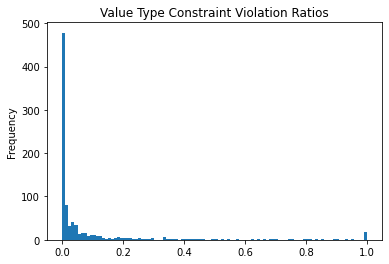

In [23]:
valTypeConstDF['violation_ratio'].plot.hist(bins=100).set_title("Value Type Constraint Violation Ratios")

Text(0.5, 1.0, 'Value Type Constraint Violation Ratios (<=0.04)')

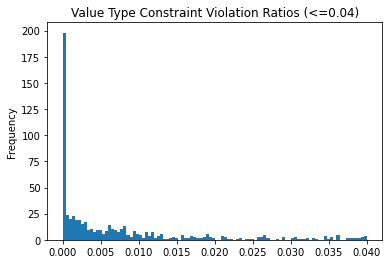

In [24]:
valTypeConstDF[valTypeConstDF['violation_ratio'] <= 0.04].violation_ratio.plot.hist(bins=100).set_title("Value Type Constraint Violation Ratios (<=0.04)")

In [25]:
print(f"No. of constraints whose violation ratio is greater than mean :{sum(valTypeConstDF['violation_ratio'] >= 3.950680)}/{len(valTypeConstDF)}")

No. of constraints whose violation ratio is greater than mean :0/897


In [26]:
for key1 in valueTypeConstViolations.keys():
    valueTypeConstViolations[key1]['correct'] = valueTypeConstViolations[key1]['instanceOf']['correct'] + valueTypeConstViolations[key1]['subclass']['correct'] + valueTypeConstViolations[key1]['instanceOfOrSubclass']['correct']
    valueTypeConstViolations[key1]['incorrect'] = valueTypeConstViolations[key1]['instanceOf']['incorrect'] + valueTypeConstViolations[key1]['subclass']['incorrect'] + valueTypeConstViolations[key1]['instanceOfOrSubclass']['incorrect']
    valueTypeConstViolations[key1]['VR'] = valueTypeConstViolations[key1]['incorrect'] / (valueTypeConstViolations[key1]['correct'] + valueTypeConstViolations[key1]['incorrect'])
        

In [27]:
valueTypeConstViolations

{'mandatory': {'instanceOf': {'correct': 11391695, 'incorrect': 5338},
  'subclass': {'correct': 44764, 'incorrect': 1},
  'instanceOfOrSubclass': {'correct': 11638, 'incorrect': 47},
  'propCount': 106,
  'correct': 11448097,
  'incorrect': 5386,
  'VR': 0.0004702499667568372},
 'suggestion': {'instanceOf': {'correct': 46036, 'incorrect': 486},
  'subclass': {'correct': 118, 'incorrect': 26},
  'instanceOfOrSubclass': {'correct': 0, 'incorrect': 0},
  'propCount': 5,
  'correct': 46154,
  'incorrect': 512,
  'VR': 0.010971585308361549},
 'normal': {'instanceOf': {'correct': 88862554, 'incorrect': 847461},
  'subclass': {'correct': 4373665, 'incorrect': 11677},
  'instanceOfOrSubclass': {'correct': 76234049, 'incorrect': 257925},
  'propCount': 786,
  'correct': 169470268,
  'incorrect': 1117063,
  'VR': 0.0065483350577775325}}

In [28]:
valTypeConstDF.to_csv('../../allConstraintsAnalysis_Final/valueTypeConstDFAnalysis.csv')

### Find out time required

In [127]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
filePath = '/data/wd-correctness/propertiesSplit_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("valueTypeConstraintValidator"):
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes

  0%|          | 0/52 [00:00<?, ?it/s]

In [128]:
print(pd.Series(times).describe())

count     897.000000
mean      352.077361
std       612.832794
min        11.407000
25%       102.123000
50%       144.146000
75%       300.513000
max      5323.176000
dtype: float64


Text(0.5, 1.0, 'Distribution of times (in s) taken for value type constraint checks')

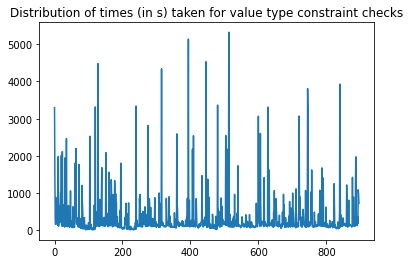

In [129]:
import seaborn as sns
sns.lineplot(data=pd.Series(times)).set_title("Distribution of times (in s) taken for value type constraint checks")


## Item Requires Statement Constraint

Here, the constraint mentions the other properties that node1 must have and the values that this property must have in few cases

For a property, codependency constraint mentions the list of other properties that this node must have. If the property mentions an exception, this listed node is exempt from this constraint. If the property mentions an item of property constraint this node-property value must have the mentioned value . Keeping this in mind, this is how we have structured the set of queries:

* Correct Statements without exceptions: Here, we extract all statements where the node has all other properties mentioned. Along with this, I also check if the values for each of the properties are as expected.


```
kgtk --debug query -i ../../propertiesSplit_Final/claims.P1421.tsv ../../propertiesSplit_Final/claims.P225.tsv ../../propertiesSplit_Final/claims.P105.tsv 
--match 'P1421: (node1)-[nodeProp]->(node2), P225: (node1)-[]->(), P105: (node1)-[]->(node2_P105)' 
--where 'node2_P105 in ["Q164280", "Q227936", "Q279749", "Q3025161", "Q3181348", "Q3238261", "Q34740", "Q35409", "Q3965313", "Q5998839", "Q630771", "Q68947", "Q7432", "Q767728"]' 
--return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'              
-o ../../allConstraintsAnalysis_Final/codependencyConstraint/Mand_Normal/claims.P1421.correct_wo_exceptions.tsv             
--graph-cache ../../sqlite3_caches/cache_new_2_1.sqlite3.db;
```

* Incorrect Statements without exceptions: Here, we just take the complement using `ifnotexists`. This might include cases where the exceptions are not exempt and hence are being called incorrect. We handle this in the next query.

```
kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims.P1421.tsv             
--filter-on ../../allConstraintsAnalysis_Final/codependencyConstraint/Mand_Normal/claims.P1421.correct_wo_exceptions.tsv 
-o ../../allConstraintsAnalysis_Final/codependencyConstraint/Mand_Normal/claims.P1421.incorrect_wo_exceptions.tsv
```

* Incorrect with exceptions: This file will have the list of statements from the incorrect file where node1 is exempted. Now, the trick we used here is that, if there are say 3 properties which have exceptions listed, we take the intersection of all the 3 lists and use it here. This would mean a node will be called as exempted only if all 3 properties have it mentioned as an exception.

```
kgtk --debug query -i ../../allConstraintsAnalysis_Final/codependencyConstraint/Mand_Normal/claims.P1421.incorrect_wo_exceptions.tsv                     
--match '(node1)-[]->()' 
--where 'node1 in ["Q18674606", "Q2591510"]'                     
-o ../../allConstraintsAnalysis_Final/codependencyConstraint/Mand_Normal/claims.P1421.incorrect_w_exceptions.tsv                     
--graph-cache ../../sqlite3_caches/cache_new_2_1.sqlite3.db;
```

* Pure incorrect set: This is `Incorrect Statements without exceptions` minus `Incorrect with exceptions`

```
kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_Final/codependencyConstraint/Mand_Normal/claims.P1421.incorrect_wo_exceptions.tsv             
--filter-on ../../allConstraintsAnalysis_Final/codependencyConstraint/Mand_Normal/claims.P1421.incorrect_w_exceptions.tsv             
-o ../../allConstraintsAnalysis_Final/codependencyConstraint/Mand_Normal/claims.P1421.incorrect.tsv;
```

* Final correct set: This is `Correct Statements without exceptions` plus `Incorrect with exceptions`

```
kgtk cat -i ../../allConstraintsAnalysis_Final/codependencyConstraint/Mand_Normal/claims.P1421.correct_wo_exceptions.tsv                     ../../allConstraintsAnalysis_Final/codependencyConstraint/Mand_Normal/claims.P1421.incorrect_w_exceptions.tsv                     
-o ../../allConstraintsAnalysis_Final/codependencyConstraint/Mand_Normal/claims.P1421.correct.tsv
```

### Understand Constraints File

In [34]:
!kgtk --debug query -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz \
    ../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz \
    --match "p: (nodeProp1)-[nodePropEdge:P2302]->(:Q21503247), q: (nodePropEdge1)-[nodePropEdgeProps]->(val)" \
    --where 'nodePropEdge.id = nodePropEdge1' \
    --return 'nodePropEdge.id as id, nodeProp1 as node1, nodePropEdgeProps.label as label, val as node2' \
    -o ../../constraintsOP/itemRequiresConstraint/claims.type-constraints_all.tsv \
    --graph-cache ../../sqlite3_caches/temp1345.valuetype.sqlite3.db

[2021-05-13 13:12:05 query]: SQL Translation:
---------------------------------------------
  SELECT graph_1_c1."id" "_aLias.id", graph_1_c1."node1" "_aLias.node1", graph_2_c2."label" "_aLias.label", graph_2_c2."node2" "_aLias.node2"
     FROM graph_1 AS graph_1_c1, graph_2 AS graph_2_c2
     WHERE graph_1_c1."label"=?
     AND graph_1_c1."node2"=?
     AND (graph_1_c1."id" = graph_2_c2."node1")
  PARAS: ['P2302', 'Q21503247']
---------------------------------------------


In [35]:
import pandas as pd
import math
dfItemRequires = pd.read_csv('../../constraintsOP/itemRequiresConstraint/claims.type-constraints_all.tsv',sep='\t')

In [36]:
dfItemRequires = dfItemRequires.groupby(['id','node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [37]:
dfItemRequires['label'].unique()

array(['P2306', 'P2305', 'P2316', 'P2304', 'P2303', 'P6607', 'P4155',
       'P31', 'P2916', 'P4680', 'P2308'], dtype=object)

In [38]:
dfItemRequires['label'].value_counts()

P2306    7182
P2305    2540
P2316    2523
P2303     422
P6607      14
P2304      14
P2916       5
P4680       2
P4155       1
P2308       1
P31         1
Name: label, dtype: int64

In [39]:
#Reference: https://stackoverflow.com/a/17298454
# dfItemRequires.pivot_table('node2', ['node1', 'id'], 'label')
dfItemRequires = dfItemRequires.pivot(index=['node1','id'], columns='label', values='node2')

In [40]:
dfItemRequires.head()

label                                  P2303 P2304   P2305   P2306 P2308  \
node1 id                                                                   
P1006 P1006-P2302-Q21503247-0451ef47-0   NaN   NaN     NaN  [P214]   NaN   
P1010 P1010-P2302-Q21503247-56183614-0   NaN   NaN     NaN   [P31]   NaN   
      P1010-P2302-Q21503247-fd256eaf-0   NaN   NaN  [Q794]   [P17]   NaN   
P1015 P1015-P2302-Q21503247-20e3bfc5-0   NaN   NaN     NaN   [P31]   NaN   
P1017 P1017-P2302-Q21503247-bbac2ce3-0   NaN   NaN     NaN  [P214]   NaN   

label                                         P2316 P2916  P31 P4155 P4680  \
node1 id                                                                     
P1006 P1006-P2302-Q21503247-0451ef47-0          NaN   NaN  NaN   NaN   NaN   
P1010 P1010-P2302-Q21503247-56183614-0          NaN   NaN  NaN   NaN   NaN   
      P1010-P2302-Q21503247-fd256eaf-0  [Q21502408]   NaN  NaN   NaN   NaN   
P1015 P1015-P2302-Q21503247-20e3bfc5-0          NaN   NaN  NaN   NaN   NaN   
P1017 P1017-P2302-Q21503247-bbac2ce3-0          NaN   NaN  NaN   NaN   NaN   

label                                  P6607  
node1 id                                      
P1006 P1006-P2302-Q21503247-0451ef47-0   NaN  
P1010 P1010-P2302-Q21503247-56183614-0   NaN  
      P1010-P2302-Q21503247-fd256eaf-0   NaN  
P1015 P1015-P2302-Q21503247-20e3bfc5-0   NaN  
P1017 P1017-P2302-Q21503247-bbac2ce3-0   NaN

In [41]:
dfItemRequires = dfItemRequires.droplevel(1)

In [42]:
dfItemRequires.head()

label,P2303,P2304,P2305,P2306,P2308,P2316,P2916,P31,P4155,P4680,P6607
node1,,,,,,,,,,,
P1006,NaN,NaN,NaN,[P214],NaN,NaN,NaN,NaN,NaN,NaN,NaN
P1010,NaN,NaN,NaN,[P31],NaN,NaN,NaN,NaN,NaN,NaN,NaN
P1010,NaN,NaN,[Q794],[P17],NaN,[Q21502408],NaN,NaN,NaN,NaN,NaN
P1015,NaN,NaN,NaN,[P31],NaN,NaN,NaN,NaN,NaN,NaN,NaN
P1017,NaN,NaN,NaN,[P214],NaN,NaN,NaN,NaN,NaN,NaN,NaN


However, there is one anomaly where the property does not have a co-dependency constraint associated with it, but still has a link to this constraint.

### Query Generator

#### Version 1 - Mandatory + Suggestion + Normal

In [66]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

fOP = None

folderName = 'codependencyConstraint'
subFolderName = "Mand_Sugg_Normal"
shellFileSuffix = 'codepConst_MSN_Validator'
graph_cache_file_prefix = "cache_new_1_"

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = mandatory + suggestion + normal
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_Final/claims.P345.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2604.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2355.tsv does not exist
File: ../../propertiesSplit_Final/claims.P3350.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1014.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2636.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1771.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2755.tsv does not exist
File: ../../propertiesSplit_Final/claims.P8326.tsv does not exist
File: ../../propertiesSplit_Final/claims.P5128.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1627.tsv does not exist
File: ../../propertiesSplit_Final/claims.P954.tsv does not exist
File: ../../propertiesSplit_Final/claims.P498.tsv does not exist
File: ../../p

In [67]:
cnt

527

In [68]:
fCnt

9

In [86]:
# import os
# for i in range(1,28):
#     os.system("screen -dm sh ../../propertiesSplit_Final/checkViolations/codepConst_MSN_Validator"+str(i)+".sh")

#### Version 2 - Mandatory + Normal

In [70]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

fOP = None

folderName = 'codependencyConstraint'
subFolderName = "Mand_Normal"
shellFileSuffix = 'codepConst_MN_Validator'
graph_cache_file_prefix = "cache_new_2_"

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = mandatory + normal
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_Final/claims.P345.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2604.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2355.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1014.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2636.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1771.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2755.tsv does not exist
File: ../../propertiesSplit_Final/claims.P8326.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1627.tsv does not exist
File: ../../propertiesSplit_Final/claims.P954.tsv does not exist
File: ../../propertiesSplit_Final/claims.P498.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1297.tsv does not exist
File: ../../propertiesSplit_Final/claims.P8680.tsv does not exist
File: ../../propertiesSplit_Final/claims.P715.tsv does not exist
File: ../../pr

In [71]:
cnt

468

In [87]:
# import os
# for i in range(1,25):
#     os.system("screen -dm sh ../../propertiesSplit_Final/checkViolations/codepConst_MN_Validator"+str(i)+".sh")

#### Version 3 - Mandatory

In [73]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

folderName = 'codependencyConstraint'
subFolderName = "Mand"
shellFileSuffix = 'codepConst_M_Validator'
graph_cache_file_prefix = "cache_3_new_"

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = mandatory
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_Final/claims.P1627.tsv does not exist


In [74]:
cnt

78

In [88]:
# import os
# for i in range(1,5):
#     os.system("screen -dm sh ../../propertiesSplit_Final/checkViolations/codepConst_M_Validator"+str(i)+".sh")

#### Version 4 - Normal

In [76]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

fOP = None

folderName = 'codependencyConstraint'
subFolderName = "Normal"
shellFileSuffix = 'codepConst_N_Validator'
graph_cache_file_prefix = "cache_4_new_"

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = normal
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv\
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_Final/claims.P345.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2604.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2355.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1014.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2636.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1771.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2755.tsv does not exist
File: ../../propertiesSplit_Final/claims.P8326.tsv does not exist
File: ../../propertiesSplit_Final/claims.P954.tsv does not exist
File: ../../propertiesSplit_Final/claims.P498.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1297.tsv does not exist
File: ../../propertiesSplit_Final/claims.P8680.tsv does not exist
File: ../../propertiesSplit_Final/claims.P715.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2606.tsv does not exist
File: ../../pr

In [77]:
cnt

418

In [1]:
# import os
# for i in range(1,23):
#     os.system("screen -dm sh ../../propertiesSplit_Final/checkViolations/codepConst_N_Validator"+str(i)+".sh")

#### Version 5 - Suggestion

In [79]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

folderName = 'codependencyConstraint'
subFolderName = "Suggestion"
shellFileSuffix = 'codepConst_S_Validator'
graph_cache_file_prefix = "codep_new_6_1_"

fOP = None

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = suggestion
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_Final/claims.P3350.tsv does not exist
File: ../../propertiesSplit_Final/claims.P5128.tsv does not exist


In [ ]:
cnt

In [2]:
# import os
# for i in range(1,6):
#     os.system("screen -dm sh ../../propertiesSplit_Final/checkViolations/codepConst_S_Validator"+str(i)+".sh")

### Analyze Violations

In [43]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt

codepConstViolations = {}
codepConstPropList = set()

# codepConstViolationsSummary = {}

for folder in tqdm(iter(['Mand_Sugg_Normal', 'Mand_Normal', 'Mand', 'Normal','Suggestion'])):
    filePath = "../../allConstraintsAnalysis_Final/codependencyConstraint/"+folder+"/"
    for filename in tqdm(os.listdir(filePath)):
        prop = filename.split(".")[1]
        correctness = filename.split(".")[2]
        if correctness not in ['correct','incorrect']:
            continue
        codepConstPropList.add(prop)
        count1 = countLines(filePath+filename)
        if folder not in codepConstViolations:
            codepConstViolations[folder] = {}
        if prop not in codepConstViolations[folder]:
            codepConstViolations[folder][prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        codepConstViolations[folder][prop][correctness] = count1
        codepConstViolations[folder][prop]['paths'].append(filePath+filename)
        
#         if folder not in codepConstViolationsSummary:
#             codepConstViolationsSummary[folder] = {'correct': 0, 'incorrect': 0}
#         codepConstViolationsSummary[folder][correctness] += count1

0it [00:00, ?it/s]

  0%|          | 0/1192 [00:00<?, ?it/s]

  0%|          | 0/1053 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/953 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

In [44]:
codepConstViolationsSummary = {}
for folder in codepConstViolations.keys():
    for prop in codepConstViolations[folder].keys():
        if folder not in codepConstViolationsSummary:
            codepConstViolationsSummary[folder] = {'correct': 0, 'incorrect': 0, 'propCount': 0}
        codepConstViolationsSummary[folder]['correct'] += codepConstViolations[folder][prop]['correct']
        codepConstViolationsSummary[folder]['incorrect'] += codepConstViolations[folder][prop]['incorrect']
        codepConstViolationsSummary[folder]['propCount'] += 1

In [45]:
for elem in codepConstViolationsSummary.keys():
    codepConstViolationsSummary[elem]['total'] = codepConstViolationsSummary[elem]['correct'] + codepConstViolationsSummary[elem]['incorrect']
    codepConstViolationsSummary[elem]['percIncorrect'] = codepConstViolationsSummary[elem]['incorrect'] / codepConstViolationsSummary[elem]['total'] * 100

In [46]:
codepConstViolationsSummary

{'Mand_Sugg_Normal': {'correct': 298173993,
  'incorrect': 4468153,
  'propCount': 527,
  'total': 302642146,
  'percIncorrect': 1.47638161407962},
 'Mand_Normal': {'correct': 273602683,
  'incorrect': 2248323,
  'propCount': 468,
  'total': 275851006,
  'percIncorrect': 0.815049773644835},
 'Mand': {'correct': 3984740,
  'incorrect': 767,
  'propCount': 78,
  'total': 3985507,
  'percIncorrect': 0.019244728462401398},
 'Normal': {'correct': 272710532,
  'incorrect': 2247659,
  'propCount': 418,
  'total': 274958191,
  'percIncorrect': 0.8174548253410643},
 'Suggestion': {'correct': 25729758,
  'incorrect': 2240178,
  'propCount': 97,
  'total': 27969936,
  'percIncorrect': 8.009235344692959}}

In [47]:
mandatoryPropCount = 0
suggestionPropCount = 0
normalPropCount = 0
for prop in tqdm(dfItemRequires.index.unique()):
    if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop +".tsv")):
        continue
    prop = str(prop)
    hasMandatory = False
    hasSuggestion = False
    hasNormal = False

    for _, constraint in dfItemRequires.loc[[prop]].iterrows():
        prop2 = constraint['P2306']
            
        if type(prop2) != list:
            continue
        prop2 = prop2[0]

        if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop2 +".tsv")):
            print(f"File: ../../propertiesSplit_Final/claims.{prop2}.tsv does not exist")
            continue
            
        if type(constraint['P2316']) == list:
            if constraint['P2316'][0] == 'Q21502408':
                hasMandatory = True
            elif constraint['P2316'][0] == 'Q62026391':
                hasSuggestion = True
        else:
            hasNormal = True
    if hasMandatory:
        mandatoryPropCount += 1
    if hasSuggestion:
        suggestionPropCount += 1
    if hasNormal:
        normalPropCount += 1

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_Final/claims.P345.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2604.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2355.tsv does not exist
File: ../../propertiesSplit_Final/claims.P3350.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1014.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2636.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1771.tsv does not exist
File: ../../propertiesSplit_Final/claims.P2755.tsv does not exist
File: ../../propertiesSplit_Final/claims.P8326.tsv does not exist
File: ../../propertiesSplit_Final/claims.P5128.tsv does not exist
File: ../../propertiesSplit_Final/claims.P1627.tsv does not exist
File: ../../propertiesSplit_Final/claims.P954.tsv does not exist
File: ../../propertiesSplit_Final/claims.P498.tsv does not exist
File: ../../p

In [48]:
print(f"No. of props having at least 1 mandatory constraint: {mandatoryPropCount}")
print(f"No. of props having at least 1 suggestion constraint: {suggestionPropCount}")
print(f"No. of props having at least 1 normal constraint: {normalPropCount}")

No. of props having at least 1 mandatory constraint: 76
No. of props having at least 1 suggestion constraint: 95
No. of props having at least 1 normal constraint: 408


#### Version 1 - Mand Sugg Normal

In [49]:
import pandas as pd
codepConstDF1 = pd.DataFrame(codepConstViolations['Mand_Sugg_Normal']).T

In [50]:
codepConstDF1

,correct,incorrect,paths
P1018,156,28,[../../allConstraintsAnalysis_Final/codependen...
P1464,35000,831,[../../allConstraintsAnalysis_Final/codependen...
P1906,316,186,[../../allConstraintsAnalysis_Final/codependen...
P2322,1207,65,[../../allConstraintsAnalysis_Final/codependen...
P2916,0,1,[../../allConstraintsAnalysis_Final/codependen...
...,...,...,...
P5460,523,29,[../../allConstraintsAnalysis_Final/codependen...
P2873,642,8,[../../allConstraintsAnalysis_Final/codependen...
P2875,3547,16,[../../allConstraintsAnalysis_Final/codependen...
P2876,51,14,[../../allConstraintsAnalysis_Final/codependen...


In [51]:
codepConstDF1['violation_ratio'] = codepConstDF1.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)

In [52]:
codepConstDF1.sort_values(by=['violation_ratio', 'incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P1111,0,46327,[../../allConstraintsAnalysis_Final/codependen...,1.0
P2302,0,42211,[../../allConstraintsAnalysis_Final/codependen...,1.0
P3063,0,549,[../../allConstraintsAnalysis_Final/codependen...,1.0
P2303,0,39,[../../allConstraintsAnalysis_Final/codependen...,1.0
P5447,0,23,[../../allConstraintsAnalysis_Final/codependen...,1.0
P5448,0,23,[../../allConstraintsAnalysis_Final/codependen...,1.0
P2308,0,17,[../../allConstraintsAnalysis_Final/codependen...,1.0
P7569,0,8,[../../allConstraintsAnalysis_Final/codependen...,1.0
P7903,0,7,[../../allConstraintsAnalysis_Final/codependen...,1.0
P574,0,4,[../../allConstraintsAnalysis_Final/codependen...,1.0


In [53]:
codepConstDF1.sort_values(by=['incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2214,2962988,711699,[../../allConstraintsAnalysis_Final/codependen...,0.193676
P734,2001246,704728,[../../allConstraintsAnalysis_Final/codependen...,0.260434
P433,31028893,435543,[../../allConstraintsAnalysis_Final/codependen...,0.013842
P195,1132062,384602,[../../allConstraintsAnalysis_Final/codependen...,0.253584
P569,4646728,241105,[../../allConstraintsAnalysis_Final/codependen...,0.049328
P131,10056935,198870,[../../allConstraintsAnalysis_Final/codependen...,0.019391
P275,5955,123578,[../../allConstraintsAnalysis_Final/codependen...,0.954027
P2860,174402886,114713,[../../allConstraintsAnalysis_Final/codependen...,0.000657
P2017,84792,101300,[../../allConstraintsAnalysis_Final/codependen...,0.544354
P570,2332611,94455,[../../allConstraintsAnalysis_Final/codependen...,0.038917


In [54]:
codepConstDF1['violation_ratio'].describe()

count    527.000000
mean       0.209456
std        0.306132
min        0.000000
25%        0.001024
50%        0.037037
75%        0.300012
max        1.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 1 - Violation Ratios')

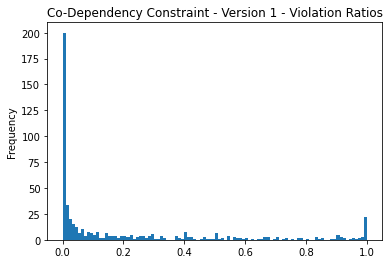

In [55]:
codepConstDF1['violation_ratio'].plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 1 - Violation Ratios")

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 1 - Violation Ratios <= 0.5')

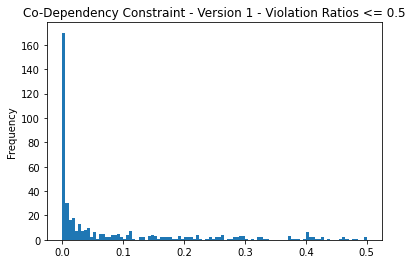

In [56]:
codepConstDF1[codepConstDF1['violation_ratio'] <= 0.5].violation_ratio.plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 1 - Violation Ratios <= 0.5")

In [57]:
print(f"No. of properties whose violation ratio is greater than mean: {sum(codepConstDF1['violation_ratio'] >= 3.539484)}/{len(codepConstDF1)}")

No. of properties whose violation ratio is greater than mean: 0/527


In [58]:
codepConstDF1.to_csv('../../allConstraintsAnalysis_Final/codepConstDFAnalysis.csv')

#### Version 2 - Mand Normal

In [59]:
import pandas as pd
codepConstDF2 = pd.DataFrame(codepConstViolations['Mand_Normal']).T

In [60]:
codepConstDF2

,correct,incorrect,paths
P1538,194334,152,[../../allConstraintsAnalysis_Final/codependen...
P2010,963,2,[../../allConstraintsAnalysis_Final/codependen...
P1018,156,28,[../../allConstraintsAnalysis_Final/codependen...
P2429,2228,236,[../../allConstraintsAnalysis_Final/codependen...
P3864,301,0,[../../allConstraintsAnalysis_Final/codependen...
...,...,...,...
P3816,17,7,[../../allConstraintsAnalysis_Final/codependen...
P3823,7376,0,[../../allConstraintsAnalysis_Final/codependen...
P3834,2070,0,[../../allConstraintsAnalysis_Final/codependen...
P3842,9338,338,[../../allConstraintsAnalysis_Final/codependen...


In [61]:
codepConstDF2['violation_ratio'] = codepConstDF2.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)

In [62]:
codepConstDF2.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2313,0,1,[../../allConstraintsAnalysis_Final/codependen...,1.0
P5448,0,23,[../../allConstraintsAnalysis_Final/codependen...,1.0
P2309,0,1,[../../allConstraintsAnalysis_Final/codependen...,1.0
P2308,0,17,[../../allConstraintsAnalysis_Final/codependen...,1.0
P2916,0,1,[../../allConstraintsAnalysis_Final/codependen...,1.0
P2307,0,1,[../../allConstraintsAnalysis_Final/codependen...,1.0
P2306,0,3,[../../allConstraintsAnalysis_Final/codependen...,1.0
P2303,0,39,[../../allConstraintsAnalysis_Final/codependen...,1.0
P7569,0,8,[../../allConstraintsAnalysis_Final/codependen...,1.0
P8264,0,1,[../../allConstraintsAnalysis_Final/codependen...,1.0


In [63]:
codepConstDF2.sort_values(by=['incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2214,2962988,711699,[../../allConstraintsAnalysis_Final/codependen...,0.193676
P433,31028893,435543,[../../allConstraintsAnalysis_Final/codependen...,0.013842
P275,5955,123578,[../../allConstraintsAnalysis_Final/codependen...,0.954027
P2860,174402886,114713,[../../allConstraintsAnalysis_Final/codependen...,0.000657
P1435,1893874,79479,[../../allConstraintsAnalysis_Final/codependen...,0.040276
P708,45253,54258,[../../allConstraintsAnalysis_Final/codependen...,0.545246
P197,117522,49904,[../../allConstraintsAnalysis_Final/codependen...,0.298066
P1598,36978,46481,[../../allConstraintsAnalysis_Final/codependen...,0.556932
P1111,0,46327,[../../allConstraintsAnalysis_Final/codependen...,1.000000
P2248,4020,41566,[../../allConstraintsAnalysis_Final/codependen...,0.911815


In [64]:
codepConstDF2['violation_ratio'].describe()

count    468.000000
mean       0.171527
std        0.285675
min        0.000000
25%        0.000690
50%        0.017889
75%        0.208292
max        1.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 2 - Violation Ratios')

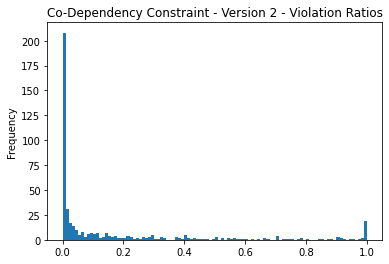

In [65]:
codepConstDF2['violation_ratio'].plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 2 - Violation Ratios")

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 2 - Violation Ratios <= 0.5')

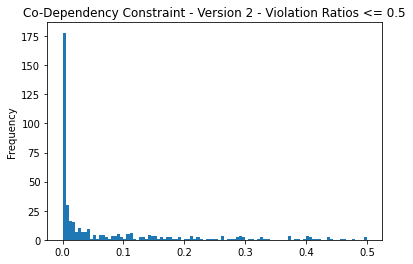

In [66]:
codepConstDF2[codepConstDF2['violation_ratio'] <= 0.5].violation_ratio.plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 2 - Violation Ratios <= 0.5")

In [67]:
print(f"No. of properties whose violation ratio is greater than mean: {sum(codepConstDF2['violation_ratio'] >= 2.290915)}/{len(codepConstDF2)}")

No. of properties whose violation ratio is greater than mean: 0/468


#### Version 3 - Mand

In [68]:
import pandas as pd
codepConstDF3 = pd.DataFrame(codepConstViolations['Mand']).T

In [69]:
codepConstDF3

,correct,incorrect,paths
P1081,12300,0,[../../allConstraintsAnalysis_Final/codependen...
P5982,1326,0,[../../allConstraintsAnalysis_Final/codependen...
P613,68854,3,[../../allConstraintsAnalysis_Final/codependen...
P1087,2587284,0,[../../allConstraintsAnalysis_Final/codependen...
P6280,721,0,[../../allConstraintsAnalysis_Final/codependen...
...,...,...,...
P517,240,0,[../../allConstraintsAnalysis_Final/codependen...
P521,1717,1,[../../allConstraintsAnalysis_Final/codependen...
P555,3876,1,[../../allConstraintsAnalysis_Final/codependen...
P5623,1472,0,[../../allConstraintsAnalysis_Final/codependen...


In [70]:
codepConstDF3['violation_ratio'] = codepConstDF3.apply(lambda p: p.incorrect / p.correct if p.correct != 0 else p.incorrect/100, axis=1)

In [71]:
codepConstDF3.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P5051,1,63,[../../allConstraintsAnalysis_Final/codependen...,63.000000
P4341,7,1,[../../allConstraintsAnalysis_Final/codependen...,0.142857
P2095,38,3,[../../allConstraintsAnalysis_Final/codependen...,0.078947
P990,966,41,[../../allConstraintsAnalysis_Final/codependen...,0.042443
P3931,2250,64,[../../allConstraintsAnalysis_Final/codependen...,0.028444
P1731,363,9,[../../allConstraintsAnalysis_Final/codependen...,0.024793
P2009,1019,15,[../../allConstraintsAnalysis_Final/codependen...,0.014720
P246,169,2,[../../allConstraintsAnalysis_Final/codependen...,0.011834
P8264,0,1,[../../allConstraintsAnalysis_Final/codependen...,0.010000
P1635,890,7,[../../allConstraintsAnalysis_Final/codependen...,0.007865


In [72]:
codepConstDF3.sort_values(by=['incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P7959,655743,376,[../../allConstraintsAnalysis_Final/codependen...,0.000573
P3931,2250,64,[../../allConstraintsAnalysis_Final/codependen...,0.028444
P5051,1,63,[../../allConstraintsAnalysis_Final/codependen...,63.000000
P915,28364,45,[../../allConstraintsAnalysis_Final/codependen...,0.001587
P990,966,41,[../../allConstraintsAnalysis_Final/codependen...,0.042443
P451,10502,36,[../../allConstraintsAnalysis_Final/codependen...,0.003428
P197,167392,34,[../../allConstraintsAnalysis_Final/codependen...,0.000203
P1560,3235,20,[../../allConstraintsAnalysis_Final/codependen...,0.006182
P2009,1019,15,[../../allConstraintsAnalysis_Final/codependen...,0.014720
P1731,363,9,[../../allConstraintsAnalysis_Final/codependen...,0.024793


In [73]:
codepConstDF3['violation_ratio'].describe()

count    78.000000
mean      0.812773
std       7.132789
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000641
max      63.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 3 - Violation Ratios')

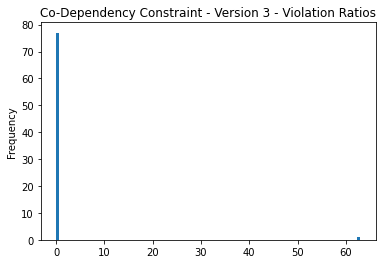

In [74]:
codepConstDF3['violation_ratio'].plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 3 - Violation Ratios")

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 3 - Violation Ratios <= 0.0005')

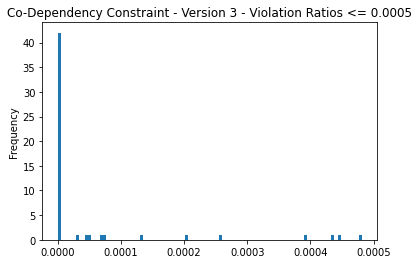

In [75]:
codepConstDF3[codepConstDF3['violation_ratio'] <= 0.0005].violation_ratio.plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 3 - Violation Ratios <= 0.0005")

In [76]:
print(f"No. of properties whose violation ratio is greater than mean: {sum(codepConstDF3['violation_ratio'] >= 0.922928)}/{len(codepConstDF3)}")

No. of properties whose violation ratio is greater than mean: 1/78


#### Version 4 - Normal

In [77]:
import pandas as pd
codepConstDF4 = pd.DataFrame(codepConstViolations['Normal']).T

In [78]:
codepConstDF4

,correct,incorrect,paths
P1540,236379,456,[../../allConstraintsAnalysis_Final/codependen...
P2660,10136,21,[../../allConstraintsAnalysis_Final/codependen...
P769,1850,0,[../../allConstraintsAnalysis_Final/codependen...
P5947,1,0,[../../allConstraintsAnalysis_Final/codependen...
P1018,156,28,[../../allConstraintsAnalysis_Final/codependen...
...,...,...,...
P4213,42542,13,[../../allConstraintsAnalysis_Final/codependen...
P4238,258,11,[../../allConstraintsAnalysis_Final/codependen...
P427,27232,26,[../../allConstraintsAnalysis_Final/codependen...
P4316,183,72,[../../allConstraintsAnalysis_Final/codependen...


In [79]:
codepConstDF4['violation_ratio'] = codepConstDF4.apply(lambda p: p.incorrect / p.correct if p.correct != 0 else p.incorrect/100, axis=1)

In [80]:
codepConstDF4.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P1111,0,46327,[../../allConstraintsAnalysis_Final/codependen...,463.270000
P1995,80,9985,[../../allConstraintsAnalysis_Final/codependen...,124.812500
P768,133,15143,[../../allConstraintsAnalysis_Final/codependen...,113.857143
P4501,419,22682,[../../allConstraintsAnalysis_Final/codependen...,54.133652
P2715,4,158,[../../allConstraintsAnalysis_Final/codependen...,39.500000
P275,5955,123578,[../../allConstraintsAnalysis_Final/codependen...,20.751973
P2376,1,19,[../../allConstraintsAnalysis_Final/codependen...,19.000000
P3912,297,3705,[../../allConstraintsAnalysis_Final/codependen...,12.474747
P2720,12,134,[../../allConstraintsAnalysis_Final/codependen...,11.166667
P2248,4020,41566,[../../allConstraintsAnalysis_Final/codependen...,10.339801


In [81]:
codepConstDF4.sort_values(by=['incorrect'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2214,2962988,711699,[../../allConstraintsAnalysis_Final/codependen...,0.240196
P433,31028893,435543,[../../allConstraintsAnalysis_Final/codependen...,0.014037
P275,5955,123578,[../../allConstraintsAnalysis_Final/codependen...,20.751973
P2860,174402886,114713,[../../allConstraintsAnalysis_Final/codependen...,0.000658
P1435,1893874,79479,[../../allConstraintsAnalysis_Final/codependen...,0.041966
P708,45253,54258,[../../allConstraintsAnalysis_Final/codependen...,1.198992
P197,117523,49903,[../../allConstraintsAnalysis_Final/codependen...,0.424623
P1598,36978,46481,[../../allConstraintsAnalysis_Final/codependen...,1.256991
P1111,0,46327,[../../allConstraintsAnalysis_Final/codependen...,463.270000
P2248,4020,41566,[../../allConstraintsAnalysis_Final/codependen...,10.339801


In [82]:
codepConstDF4['violation_ratio'].describe()

count    418.000000
mean       2.454376
std       24.333809
min        0.000000
25%        0.001419
50%        0.026024
75%        0.237647
max      463.270000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 4 - Violation Ratios')

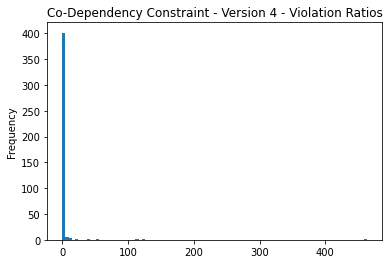

In [83]:
codepConstDF4['violation_ratio'].plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 4 - Violation Ratios")

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 4 - Violation Ratios <= 0.5')

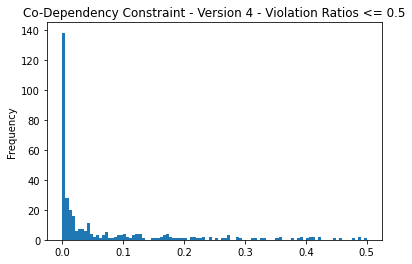

In [84]:
codepConstDF4[codepConstDF4['violation_ratio'] <= 0.5].violation_ratio.plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 4 - Violation Ratios <= 0.5")

In [85]:
print(f"No. of properties whose violation ratio is greater than mean: {sum(codepConstDF4['violation_ratio'] >= 2.414703)}/{len(codepConstDF4)}")

No. of properties whose violation ratio is greater than mean: 25/418


### Find out time required

In [86]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
timesVersion = {"MSN": [], "MN": [], "M": [], "N": [], "S": []}
filePath = '/data/wd-correctness/propertiesSplit_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("timeLog_codepConst_"):
        ver = filename.split('_')[2]
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes
        timesVersion[ver] += tempTimes
print(pd.Series(times).describe())

  0%|          | 0/54 [00:00<?, ?it/s]

count    1588.000000
mean       33.859051
std       152.985712
min         1.297000
25%         2.227750
50%         4.343500
75%        12.581250
max      2828.460000
dtype: float64


In [3]:
print(pd.Series(timesVersion['MSN']).describe())

count     527.000000
mean      133.514751
std       219.717844
min         1.899000
25%        25.236500
50%        58.603000
75%       145.354000
max      2199.569000
dtype: float64


In [4]:
print(pd.Series(timesVersion['MN']).describe())

count     468.000000
mean      131.495897
std       232.398622
min         1.780000
25%        19.863500
50%        50.195000
75%       147.243250
max      2783.638000
dtype: float64


In [133]:
print(pd.Series(timesVersion['M']).describe())

count     78.000000
mean     158.441372
std      205.424068
min        2.758000
25%       22.989000
50%       72.119500
75%      207.367000
max      848.583000
dtype: float64


In [134]:
print(pd.Series(timesVersion['N']).describe())

count     418.000000
mean      128.126914
std       222.603826
min         2.543000
25%        19.653000
50%        50.284500
75%       140.122000
max      2891.457000
dtype: float64


## Symmetric Constraint (Q21510862)

This constraint says, if node1 has a property with this constraint, then both `(node1)-[prop]->(node2)` and `(node2)-[prop]->(node1)` must be present with few exceptions

### Constraints File

In [107]:
!kgtk --debug query -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz \
    ../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz \
    --match "p: (nodeProp1)-[nodePropEdge:P2302]->(:Q21510862)" \
    -o ../../constraintsOP/symmetricConstraint/claims.constraints_list.tsv \
    --graph-cache ../../sqlite3_caches/temp1345.valuetype.sqlite3.db

[2021-05-13 23:11:42 query]: SQL Translation:
---------------------------------------------
  SELECT *
     FROM graph_1 AS graph_1_c1
     WHERE graph_1_c1."label"=?
     AND graph_1_c1."node2"=?
  PARAS: ['P2302', 'Q21510862']
---------------------------------------------


In [108]:
import pandas as pd
qualiDF = pd.read_csv("../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz",sep='\t')
constDF = pd.read_csv("../../constraintsOP/symmetricConstraint/claims.constraints_list.tsv",sep='\t')

In [109]:
constDF2 = constDF.set_index('id').join(qualiDF.set_index('node1'),rsuffix='_qualifier').drop(columns=['id', 'node2;wikidatatype_qualifier', 'rank', 'node2', 'label', 'node2;wikidatatype']).rename(columns={'label_qualifier':'label', 'node2_qualifier': 'node2'})
constDF2 = constDF2.reset_index()
constDF2 = constDF2.rename(columns={'index':'id'})
constDF2['label'] = constDF2.label.fillna("P2316")
constDF2['node2'] = constDF2.node2.fillna("Normal")

In [110]:
constDF2.to_csv("../../constraintsOP/symmetricConstraint/claims.constraints_all.tsv",sep="\t",index=False)

In [111]:
import pandas as pd
import math
dfItemRequires = pd.read_csv('../../constraintsOP/symmetricConstraint/claims.constraints_all.tsv',sep='\t')

In [112]:
dfItemRequires = dfItemRequires.groupby(['id','node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [113]:
dfItemRequires['label'].unique()

array(['P2316', 'P2303'], dtype=object)

In [114]:
dfItemRequires['label'].value_counts()

P2316    42
P2303     3
Name: label, dtype: int64

In [115]:
#Reference: https://stackoverflow.com/a/17298454
# dfItemRequires.pivot_table('node2', ['node1', 'id'], 'label')
dfItemRequires = dfItemRequires.pivot(index=['node1','id'], columns='label', values='node2')

In [116]:
dfItemRequires.head()

,label,P2303,P2316
node1,id,,
P1322,P1322-P2302-Q21510862-85dea891-0,NaN,[Normal]
P1327,P1327-P2302-Q21510862-a3c3a094-0,NaN,[Normal]
P1382,P1382-P2302-Q21510862-f6bcfecf-0,NaN,[Normal]
P1560,P1560-P2302-Q21510862-fabecaeb-0,NaN,[Q21502408]
P1639,P1639-P2302-Q21510862-384edcd4-0,NaN,[Q21502408]


In [117]:
dfItemRequires = dfItemRequires.droplevel(1)

In [118]:
dfItemRequires.head()

label,P2303,P2316
node1,,
P1322,NaN,[Normal]
P1327,NaN,[Normal]
P1382,NaN,[Normal]
P1560,NaN,[Q21502408]
P1639,NaN,[Q21502408]


### Query Generator

In [121]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

folderName = 'symmetricConstraint'
shellFileSuffix = 'symmConst_Validator_'
graph_cache_prefix = 'symm_new_1_1_'

for row in tqdm(dfItemRequires.iterrows()):
#     try:
        prop = row[0]
        constraint = row[1]
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        if type(constraint['P2316']) == list:
            if constraint['P2316'][0] == 'Q21502408':
                sfname = 'mandatory'
            elif constraint['P2316'][0] == 'Q62026391':
                sfname = 'suggestion'
            elif constraint['P2316'][0] == 'Normal':
                sfname = 'normal'
        else:
            sfname = 'normal'
        
        if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop +".tsv")):
            continue
                
        command = "{ time ( kgtk --debug query -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
                    ../../propertiesSplit_Final/claims."+ prop +".copy2.tsv \
                    --match 'tsv: (node1)-[nodeProp]->(node2), copy2: (node2)-[]->(node1)' "
        
        os.system("cp ../../propertiesSplit_Final/claims."+ prop +".tsv ../../propertiesSplit_Final/claims."+ prop +".copy2.tsv")
        
        if cnt % 60 == 0:
            fCnt += 1
            fOP = open("../../propertiesSplit_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        command
        if type(constraint['P2303']) != list: # Exceptions not present
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct.tsv \
            --graph-cache ../../sqlite3_caches/"+graph_cache_prefix+"_" + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n"
#             print(command)
            fOP.write(command)
        else:
            excptns = constraint['P2303']
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ../../sqlite3_caches/"+graph_cache_prefix+"_" + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv; "
#             print(command)
            fOP.write(command)
            
            command = " kgtk --debug query -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims." + prop + ".correct_exceptions.tsv \
                    --graph-cache ../../sqlite3_caches/"+graph_cache_prefix+"_" + str(fCnt) + ".sqlite3.db; "
#             print(command)
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims." + prop + ".correct_exceptions.tsv \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims."+ prop +".incorrect.tsv; "
#             print(command)
            fOP.write(command)
            
            command = " kgtk cat -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n"
#             print(command)
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)

0it [00:00, ?it/s]

In [122]:
cnt

38

In [123]:
# import os
# for i in range(1,3):
#     os.system("screen -dm sh ../../propertiesSplit_Final/checkViolations/symmConst_Validator_"+str(i)+".sh")

### Analyze Violations

In [143]:
import pandas as pd
import os
from tqdm.notebook import tqdm

symmConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt 

symmConstViolations = {}
symmConstPropList = set()

# codepConstViolationsSummary = {}


filePath = "../../allConstraintsAnalysis_Final/symmetricConstraint/"
for folder in tqdm(iter(['mandatory','normal','suggestion'])):
    for filename in tqdm(os.listdir(filePath + folder)):
        prop = filename.split(".")[1]
        correctness = filename.split(".")[2]
        if correctness not in ['correct','incorrect']:
            continue
        symmConstPropList.add(prop)
        count1 = countLines(filePath+folder+'/'+filename)
        if folder not in symmConstViolations:
            symmConstViolations[folder] = {}
        if prop not in symmConstViolations[folder]:
            symmConstViolations[folder][prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        symmConstViolations[folder][prop][correctness] = count1
        symmConstViolations[folder][prop]['paths'].append(filePath+folder+'/'+filename)

0it [00:00, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [144]:
len(symmConstPropList)

38

In [145]:
symmConstViolationsSummary = {}
for folder in tqdm(iter(['mandatory','normal','suggestion'])):
    symmConstViolationsSummary[folder] = {'correct': 0, 'incorrect': 0}
    for prop in symmConstViolations[folder].keys():
        symmConstViolationsSummary[folder]['correct'] += symmConstViolations[folder][prop]['correct']
        symmConstViolationsSummary[folder]['incorrect'] += symmConstViolations[folder][prop]['incorrect']
    symmConstViolationsSummary[folder]['total'] = symmConstViolationsSummary[folder]['correct'] + symmConstViolationsSummary[folder]['incorrect']
    symmConstViolationsSummary[folder]['percIncorrect'] = symmConstViolationsSummary[folder]['incorrect'] / symmConstViolationsSummary[folder]['total'] * 100
    symmConstViolationsSummary[folder]['propCount'] = len(symmConstViolations[folder].keys())

0it [00:00, ?it/s]

In [146]:
symmConstViolationsSummary

{'mandatory': {'correct': 7432,
  'incorrect': 42,
  'total': 7474,
  'percIncorrect': 0.561948086700562,
  'propCount': 5},
 'normal': {'correct': 6230891,
  'incorrect': 78884,
  'total': 6309775,
  'percIncorrect': 1.2501872095280735,
  'propCount': 30},
 'suggestion': {'correct': 773722,
  'incorrect': 54226,
  'total': 827948,
  'percIncorrect': 6.549445134235484,
  'propCount': 3}}

In [147]:
noOfStmts = 0
for fold in symmConstViolationsSummary.keys():
    noOfStmts += symmConstViolationsSummary[fold]['total']
noOfStmts

7145197

In [148]:
symmConstDF1 = pd.DataFrame(symmConstViolations['mandatory']).T
symmConstDF1['violation_ratio'] = symmConstDF1.apply(lambda p: p.incorrect / (p.incorrect + p.correct), axis=1)
symmConstDF1.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2152,75,1,[../../allConstraintsAnalysis_Final/symmetricC...,0.013158
P1639,2059,21,[../../allConstraintsAnalysis_Final/symmetricC...,0.010096
P1560,3235,20,[../../allConstraintsAnalysis_Final/symmetricC...,0.006144
P3364,1784,0,[../../allConstraintsAnalysis_Final/symmetricC...,0.000000
P6185,279,0,[../../allConstraintsAnalysis_Final/symmetricC...,0.000000


In [149]:
symmConstDF2 = pd.DataFrame(symmConstViolations['suggestion']).T
symmConstDF2['violation_ratio'] = symmConstDF2.apply(lambda p: p.incorrect / (p.incorrect + p.correct), axis=1)
symmConstDF2.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2789,103536,22758,[../../allConstraintsAnalysis_Final/symmetricC...,0.180199
P1889,505837,28391,[../../allConstraintsAnalysis_Final/symmetricC...,0.053144
P197,164349,3077,[../../allConstraintsAnalysis_Final/symmetricC...,0.018378


In [150]:
symmConstDF3 = pd.DataFrame(symmConstViolations['normal']).T
symmConstDF3['violation_ratio'] = symmConstDF3.apply(lambda p: p.incorrect / (p.incorrect + p.correct), axis=1)
symmConstDF3.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P5188,0,2,[../../allConstraintsAnalysis_Final/symmetricC...,1.000000
P1706,4,52,[../../allConstraintsAnalysis_Final/symmetricC...,0.928571
P521,418,1300,[../../allConstraintsAnalysis_Final/symmetricC...,0.756694
P2652,460,852,[../../allConstraintsAnalysis_Final/symmetricC...,0.649390
P8702,6,2,[../../allConstraintsAnalysis_Final/symmetricC...,0.250000
P1382,10622,2811,[../../allConstraintsAnalysis_Final/symmetricC...,0.209261
P2293,9980,2230,[../../allConstraintsAnalysis_Final/symmetricC...,0.182637
P3032,1674,345,[../../allConstraintsAnalysis_Final/symmetricC...,0.170877
P451,9520,1018,[../../allConstraintsAnalysis_Final/symmetricC...,0.096603
P1327,7734,758,[../../allConstraintsAnalysis_Final/symmetricC...,0.089260


Text(0.5, 1.0, 'Symmetric Normal Constraint - Violation Ratios')

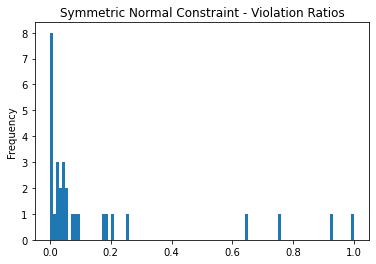

In [151]:
symmConstDF3.sort_values(by=['violation_ratio'],ascending=False)['violation_ratio'].plot.hist(bins=100).set_title("Symmetric Normal Constraint - Violation Ratios")

In [152]:
pd.concat([symmConstDF1, symmConstDF2, symmConstDF3]).to_csv('../../allConstraintsAnalysis_Final/symmConstDFAnalysis.csv')

### Find out time required

In [135]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
filePath = '/data/wd-correctness/propertiesSplit_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("symmConst_Validator_"):
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes

  0%|          | 0/52 [00:00<?, ?it/s]

In [136]:
print(pd.Series(times).describe())

count     38.000000
mean     118.440816
std      119.145724
min        9.715000
25%       40.780500
50%       68.670000
75%      135.589750
max      527.332000
dtype: float64


Text(0.5, 1.0, 'Distribution of times (in s) taken for symmetric constraint checks')

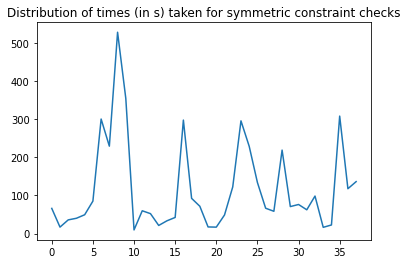

In [137]:
import seaborn as sns
sns.lineplot(data=pd.Series(times)).set_title("Distribution of times (in s) taken for symmetric constraint checks")

## Inverse Constraint (Q21510855)

This constraint says, if node1 has a property with this constraint, then node2 must have the specified property and the value must be node1.

### Constraints File

In [124]:
!kgtk --debug query -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz \
    ../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz \
    --match "p: (nodeProp1)-[nodePropEdge:P2302]->(:Q21510855)" \
    -o ../../constraintsOP/inverseConstraint/claims.constraints_list.tsv \
    --graph-cache ../../sqlite3_caches/temp1345.valuetype.sqlite3.db

[2021-05-13 23:13:26 query]: SQL Translation:
---------------------------------------------
  SELECT *
     FROM graph_1 AS graph_1_c1
     WHERE graph_1_c1."label"=?
     AND graph_1_c1."node2"=?
  PARAS: ['P2302', 'Q21510855']
---------------------------------------------


In [125]:
import pandas as pd
qualiDF = pd.read_csv("../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz",sep='\t')
constDF = pd.read_csv("../../constraintsOP/inverseConstraint/claims.constraints_list.tsv",sep='\t')

In [126]:
constDF2 = constDF.set_index('id').join(qualiDF.set_index('node1'),rsuffix='_qualifier').drop(columns=['id', 'node2;wikidatatype_qualifier', 'rank', 'node2', 'label', 'node2;wikidatatype']).rename(columns={'label_qualifier':'label', 'node2_qualifier': 'node2'})
constDF2 = constDF2.reset_index()
constDF2 = constDF2.rename(columns={'index':'id'})
constDF2['label'] = constDF2.label.fillna("P2316")
constDF2['node2'] = constDF2.node2.fillna("Normal")

In [127]:
constDF2.to_csv("../../constraintsOP/inverseConstraint/claims.constraints_all.tsv",sep="\t",index=False)

In [128]:
import pandas as pd
import math
dfItemRequires = pd.read_csv('../../constraintsOP/inverseConstraint/claims.constraints_all.tsv',sep='\t')

In [129]:
dfItemRequires = dfItemRequires.groupby(['id','node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [130]:
dfItemRequires['label'].unique()

array(['P2306', 'P2316', 'P4155', 'P2303'], dtype=object)

In [131]:
dfItemRequires['label'].value_counts()

P2306    110
P2316     10
P2303      2
P4155      1
Name: label, dtype: int64

In [132]:
#Reference: https://stackoverflow.com/a/17298454
# dfItemRequires.pivot_table('node2', ['node1', 'id'], 'label')
dfItemRequires = dfItemRequires.pivot(index=['node1','id'], columns='label', values='node2')

In [133]:
dfItemRequires.head()

,label,P2303,P2306,P2316,P4155
node1,id,,,,
P1026,P1026-P2302-Q21510855-adc83b86-0,NaN,[P50],NaN,NaN
P1029,P1029-P2302-Q21510855-6b55e057-0,NaN,[P5096],NaN,NaN
P115,P115-P2302-Q21510855-f7aa0b78-0,NaN,[P466],NaN,NaN
P1151,P1151-P2302-Q21510855-0d9aa9c6-0,NaN,[P1204],[Q21502408],NaN
P1204,P1204-P2302-Q21510855-e3d53bb6-0,NaN,[P1151],NaN,NaN


In [134]:
dfItemRequires = dfItemRequires.droplevel(1)

In [135]:
dfItemRequires.head()

label,P2303,P2306,P2316,P4155
node1,,,,
P1026,NaN,[P50],NaN,NaN
P1029,NaN,[P5096],NaN,NaN
P115,NaN,[P466],NaN,NaN
P1151,NaN,[P1204],[Q21502408],NaN
P1204,NaN,[P1151],NaN,NaN


### Query Generator

In [136]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0
fOP = None

folderName = 'inverseConstraint'
shellFileSuffix = 'invConst_Validator_'
graph_cache_file_prefix = "inv_new_1_1_"

for prop, constraint in tqdm(dfItemRequires.iterrows()):
#     try:
        
        if type(constraint['P2316']) == list:
            if constraint['P2316'][0] == 'Q21502408':
                subFolderName = "mandatory"
            elif constraint['P2316'][0] == 'Q62026391':
                subFolderName = "suggestion"
        else:
            subFolderName = "normal"
        
        if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop +".tsv")):
            continue
            
        prop2 = constraint['P2306']

        if type(prop2) != list:
            continue
        prop2 = prop2[0]

        if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop2 +".tsv")):
            print(f"File: ../../propertiesSplit_Final/claims.{prop2}.tsv does not exist")
            continue
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
            
        command = "{ time ( kgtk --debug query -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
                        ../../propertiesSplit_Final/claims."+ prop2 +".tsv \
                        --match '"+ \
                        f"{prop}: (node1)-[nodeProp]->(node2), {prop2}: (node2)-[]->(node1)' "

        if type(constraint['P2303']) != list: # Exceptions not present
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n"
#             print(command)
            fOP.write(command)
        else:
            excptns = set(constraint['P2303'])
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv; "
#             print(command)
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ../../sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
#             print(command)        
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
#             print(command)
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt; \n"
#             print(command)
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

0it [00:00, ?it/s]

In [137]:
cnt

110

In [138]:
# import os
# for i in range(1,7):
#     os.system("screen -dm sh ../../propertiesSplit_Final/checkViolations/invConst_Validator_"+str(i)+".sh")

### Analyze Violations

In [153]:
import pandas as pd
import os
from tqdm.notebook import tqdm

invConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt

invConstViolations = {}
invConstPropList = set()

# codepConstViolationsSummary = {}


filePath = "../../allConstraintsAnalysis_Final/inverseConstraint/"
for folder in tqdm(iter(['mandatory','normal','suggestion'])):
    for filename in tqdm(os.listdir(filePath + folder)):
        prop = filename.split(".")[1]
        correctness = filename.split(".")[2]
        if correctness not in ['correct','incorrect']:
            continue
        invConstPropList.add(prop)
        count1 = countLines(filePath+folder+'/'+filename)
        if folder not in invConstViolations:
            invConstViolations[folder] = {}
        if prop not in invConstViolations[folder]:
            invConstViolations[folder][prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        invConstViolations[folder][prop][correctness] = count1
        invConstViolations[folder][prop]['paths'].append(filePath+folder+'/'+filename)

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [154]:
len(invConstPropList)

110

In [155]:
invConstViolationsSummary = {}
for folder in tqdm(iter(['mandatory','normal','suggestion'])):
    invConstViolationsSummary[folder] = {'correct': 0, 'incorrect': 0}
    for prop in invConstViolations[folder].keys():
        invConstViolationsSummary[folder]['correct'] += invConstViolations[folder][prop]['correct']
        invConstViolationsSummary[folder]['incorrect'] += invConstViolations[folder][prop]['incorrect']
    invConstViolationsSummary[folder]['total'] = invConstViolationsSummary[folder]['correct'] + invConstViolationsSummary[folder]['incorrect']
    invConstViolationsSummary[folder]['percIncorrect'] = invConstViolationsSummary[folder]['incorrect'] / invConstViolationsSummary[folder]['total'] * 100
    invConstViolationsSummary[folder]['propCount'] = len(invConstViolations[folder].keys())

0it [00:00, ?it/s]

In [156]:
invConstViolationsSummary

{'mandatory': {'correct': 6564,
  'incorrect': 133,
  'total': 6697,
  'percIncorrect': 1.9859638644169029,
  'propCount': 6},
 'normal': {'correct': 7131934,
  'incorrect': 204841,
  'total': 7336775,
  'percIncorrect': 2.7919760385182864,
  'propCount': 100},
 'suggestion': {'correct': 2002102,
  'incorrect': 95351,
  'total': 2097453,
  'percIncorrect': 4.546037503581725,
  'propCount': 4}}

In [157]:
noOfStmts = 0
for fold in invConstViolationsSummary.keys():
    noOfStmts += invConstViolationsSummary[fold]['total']
noOfStmts

9440925

In [158]:
invConstDF1 = pd.DataFrame(invConstViolations['mandatory']).T
invConstDF1['violation_ratio'] = invConstDF1.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)
invConstDF1.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P2673,819,69,[../../allConstraintsAnalysis_Final/inverseCon...,0.077703
P4147,271,9,[../../allConstraintsAnalysis_Final/inverseCon...,0.032143
P4149,272,4,[../../allConstraintsAnalysis_Final/inverseCon...,0.014493
P2033,1836,26,[../../allConstraintsAnalysis_Final/inverseCon...,0.013963
P450,1754,21,[../../allConstraintsAnalysis_Final/inverseCon...,0.011831
P1151,1612,4,[../../allConstraintsAnalysis_Final/inverseCon...,0.002475


In [159]:
invConstDF2 = pd.DataFrame(invConstViolations['suggestion']).T
invConstDF2['violation_ratio'] = invConstDF2.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)
invConstDF2.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P1434,3512,4745,[../../allConstraintsAnalysis_Final/inverseCon...,0.574664
P155,963205,49783,[../../allConstraintsAnalysis_Final/inverseCon...,0.049145
P156,963183,40682,[../../allConstraintsAnalysis_Final/inverseCon...,0.040525
P629,72202,141,[../../allConstraintsAnalysis_Final/inverseCon...,0.001949


In [160]:
invConstDF3 = pd.DataFrame(invConstViolations['normal']).T
invConstDF3['violation_ratio'] = invConstDF3.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)
invConstDF3.sort_values(by=['violation_ratio'],ascending=False).head(15)

,correct,incorrect,paths,violation_ratio
P1605,12,189,[../../allConstraintsAnalysis_Final/inverseCon...,0.940299
P3448,583,4266,[../../allConstraintsAnalysis_Final/inverseCon...,0.879769
P926,1,6,[../../allConstraintsAnalysis_Final/inverseCon...,0.857143
P925,1,5,[../../allConstraintsAnalysis_Final/inverseCon...,0.833333
P1029,475,2263,[../../allConstraintsAnalysis_Final/inverseCon...,0.826516
P115,6712,24515,[../../allConstraintsAnalysis_Final/inverseCon...,0.785058
P8625,7,17,[../../allConstraintsAnalysis_Final/inverseCon...,0.708333
P5132,81,89,[../../allConstraintsAnalysis_Final/inverseCon...,0.523529
P425,2512,2024,[../../allConstraintsAnalysis_Final/inverseCon...,0.446208
P3816,14,10,[../../allConstraintsAnalysis_Final/inverseCon...,0.416667


Text(0.5, 1.0, 'Symmetric Normal Constraint - Violation Ratios')

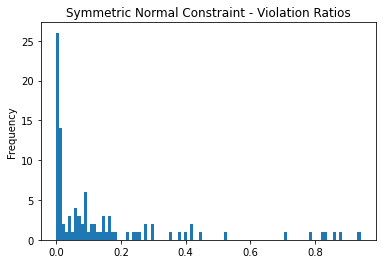

In [161]:
invConstDF3.sort_values(by=['violation_ratio'],ascending=False)['violation_ratio'].plot.hist(bins=100).set_title("Symmetric Normal Constraint - Violation Ratios")

In [162]:
pd.concat([invConstDF1, invConstDF2, invConstDF3]).to_csv('../../allConstraintsAnalysis_Final/invConstDFAnalysis.csv')

### Find out time required

In [138]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
filePath = '/data/wd-correctness/propertiesSplit_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("invConst_Validator"):
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes

  0%|          | 0/52 [00:00<?, ?it/s]

In [139]:
print(pd.Series(times).describe())

count    110.000000
mean     100.688809
std      111.183132
min        8.677000
25%       32.859750
50%       54.791000
75%      119.579750
max      646.215000
dtype: float64


Text(0.5, 1.0, 'Distribution of times (in s) taken for symmetric constraint checks')

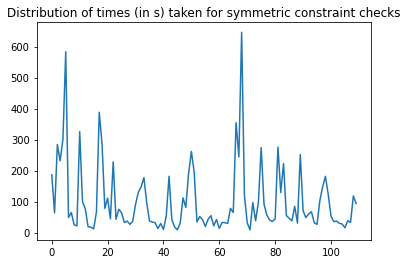

In [140]:
import seaborn as sns
sns.lineplot(data=pd.Series(times)).set_title("Distribution of times (in s) taken for symmetric constraint checks")

# Combine Plots for constraints

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

typeConstDF = pd.read_csv("../../allConstraintsAnalysis_Final/typeConstDFAnalysis.csv")
typeConstDF = typeConstDF.set_index(typeConstDF.iloc[:, 0])

valTypeConstDF = pd.read_csv("../../allConstraintsAnalysis_Final/valueTypeConstDFAnalysis.csv")
valTypeConstDF = valTypeConstDF.set_index(valTypeConstDF.iloc[:, 0])

codepConstDF1 = pd.read_csv("../../allConstraintsAnalysis_Final/codepConstDFAnalysis.csv")
codepConstDF1 = codepConstDF1.set_index(codepConstDF1.iloc[:, 0])

symmConstDF = pd.read_csv("../../allConstraintsAnalysis_Final/symmConstDFAnalysis.csv")
symmConstDF = symmConstDF.set_index(symmConstDF.iloc[:, 0])

invConstDF = pd.read_csv("../../allConstraintsAnalysis_Final/invConstDFAnalysis.csv")
invConstDF = invConstDF.set_index(invConstDF.iloc[:, 0])

In [ ]:
typeConstDF1 = typeConstDF.add_suffix("_type_const")['violation_ratio_type_const'].rename().sort_values()

In [ ]:
valTypeConstDF1 = valTypeConstDF.add_suffix("_valuetype_const")['violation_ratio_valuetype_const'].sort_values()

In [ ]:
codepConstDF1_1 = codepConstDF1.add_suffix("_codep_const")['violation_ratio_codep_const'].sort_values()

In [ ]:
symmConstDF1_1 = symmConstDF.add_suffix("_symm_const")['violation_ratio_symm_const'].sort_values()

In [ ]:
invConstDF1_1 = invConstDF.add_suffix("_inv_const")['violation_ratio_inv_const'].sort_values()

In [ ]:
typeConstDF1.index.names = ['property']
typeConstDF1 = typeConstDF1.reset_index().reset_index()
typeConstDF1['index'] = typeConstDF1['index'].apply(lambda p: (p+1) * 100/len(typeConstDF1))
typeConstDF1 = typeConstDF1.set_index('index')[0]

In [ ]:
valTypeConstDF1.index.names = ['property']
valTypeConstDF1 = valTypeConstDF1.reset_index().reset_index()
valTypeConstDF1['index'] = valTypeConstDF1['index'].apply(lambda p: (p+1) * 100/len(valTypeConstDF1))
valTypeConstDF1 = valTypeConstDF1.set_index('index')['violation_ratio_valuetype_const']

In [ ]:
codepConstDF1_1.index.names = ['property']
codepConstDF1_1 = codepConstDF1_1.reset_index().reset_index()
codepConstDF1_1['index'] = codepConstDF1_1['index'].apply(lambda p: (p+1) * 100/len(codepConstDF1_1))
codepConstDF1_1 = codepConstDF1_1.set_index('index')['violation_ratio_codep_const']

In [ ]:
symmConstDF1_1.index.names = ['property']
symmConstDF1_1 = symmConstDF1_1.reset_index().reset_index()
symmConstDF1_1['index'] = symmConstDF1_1['index'].apply(lambda p: (p+1) * 100/len(symmConstDF1_1))
symmConstDF1_1 = symmConstDF1_1.set_index('index')['violation_ratio_symm_const']

In [ ]:
invConstDF1_1.index.names = ['property']
invConstDF1_1 = invConstDF1_1.reset_index().reset_index()
invConstDF1_1['index'] = invConstDF1_1['index'].apply(lambda p: (p+1) * 100/len(invConstDF1_1))
invConstDF1_1 = invConstDF1_1.set_index('index')['violation_ratio_inv_const']

In [ ]:
typeConstDF2 = [np.percentile(typeConstDF1,i)*100 for i in range(1, 101)]
valTypeConstDF2 = [np.percentile(valTypeConstDF1,i)*100 for i in range(1, 101)]
codepConstDF1_2 = [np.percentile(codepConstDF1_1,i)*100 for i in range(1, 101)]
symmConstDF1_2 = [np.percentile(symmConstDF1_1,i)*100 for i in range(1, 101)]
invConstDF1_2 = [np.percentile(invConstDF1_1,i)*100 for i in range(1, 101)]

In [ ]:
constAnalysisDF = pd.DataFrame({'index':list(range(1, 101)), 'type': typeConstDF2, 'value type': valTypeConstDF2, 'irs': codepConstDF1_2, 'symmetric': symmConstDF1_2, 'inverse': invConstDF1_2})

In [ ]:
constAnalysisDF = constAnalysisDF.melt('index', var_name='constraint',  value_name='VR')

In [ ]:
constAnalysisDF.head()

[Text(0.5, 0, 'Proportion of properties (in %)'),
 Text(0, 0.5, 'Violation Ratio (in %)')]

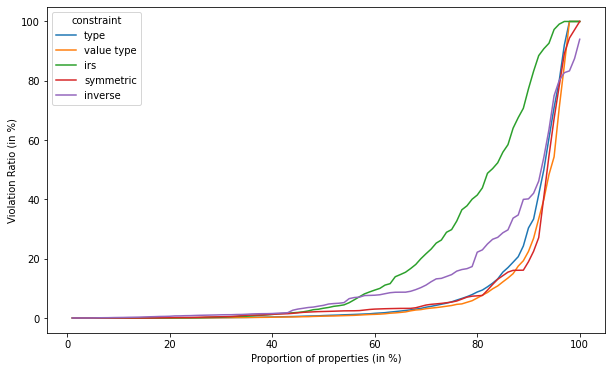

In [33]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='index', y='VR', hue='constraint', data=constAnalysisDF)
ax.set(xlabel="Proportion of properties (in %)", ylabel = "Violation Ratio (in %)")

## Scatterplot

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

typeConstDF = pd.read_csv("../../allConstraintsAnalysis_Final/typeConstDFAnalysis.csv")
typeConstDF = typeConstDF.set_index(typeConstDF.iloc[:, 0])

valTypeConstDF = pd.read_csv("../../allConstraintsAnalysis_Final/valueTypeConstDFAnalysis.csv")
valTypeConstDF = valTypeConstDF.set_index(valTypeConstDF.iloc[:, 0])

codepConstDF1 = pd.read_csv("../../allConstraintsAnalysis_Final/codepConstDFAnalysis.csv")
codepConstDF1 = codepConstDF1.set_index(codepConstDF1.iloc[:, 0])

symmConstDF = pd.read_csv("../../allConstraintsAnalysis_Final/symmConstDFAnalysis.csv")
symmConstDF = symmConstDF.set_index(symmConstDF.iloc[:, 0])

invConstDF = pd.read_csv("../../allConstraintsAnalysis_Final/invConstDFAnalysis.csv")
invConstDF = invConstDF.set_index(invConstDF.iloc[:, 0])

In [8]:
typeConstDF1 = typeConstDF.add_suffix("_type_const")[['violation_ratio_type_const']].sort_values(by=['violation_ratio_type_const'],ascending=False)
valTypeConstDF1 = valTypeConstDF.add_suffix("_valuetype_const")[['violation_ratio_valuetype_const']].sort_values(by=['violation_ratio_valuetype_const'],ascending=False)
codepConstDF1_1 = codepConstDF1.add_suffix("_codep_const")[['violation_ratio_codep_const']].sort_values(by=['violation_ratio_codep_const'],ascending=False)
symmConstDF1_1 = symmConstDF.add_suffix("_symm_const")[['violation_ratio_symm_const']].sort_values(by=['violation_ratio_symm_const'],ascending=False)
invConstDF1_1 = invConstDF.add_suffix("_inv_const")[['violation_ratio_inv_const']].sort_values(by=['violation_ratio_inv_const'],ascending=False)
invConstDF1_1.head()

,violation_ratio_inv_const
Unnamed: 0,
P1605,0.940299
P3448,0.879769
P926,0.857143
P925,0.833333
P1029,0.826516


In [9]:
len(typeConstDF1), len(valTypeConstDF1), len(codepConstDF1_1), len(symmConstDF), len(invConstDF1_1)

(1456, 897, 527, 38, 110)

In [10]:
typeConstDF1.index.names = ['property']
typeConstDF1 = typeConstDF1.reset_index()[['violation_ratio_type_const']]
valTypeConstDF1.index.names = ['property']
valTypeConstDF1 = valTypeConstDF1.reset_index()[['violation_ratio_valuetype_const']]
codepConstDF1_1.index.names = ['property']
codepConstDF1_1 = codepConstDF1_1.reset_index()[['violation_ratio_codep_const']]
symmConstDF1_1.index.names = ['property']
symmConstDF1_1 = symmConstDF1_1.reset_index()[['violation_ratio_symm_const']]
invConstDF1_1.index.names = ['property']
invConstDF1_1 = invConstDF1_1.reset_index()[['violation_ratio_inv_const']]

import numpy as np

typeConstDF2 = pd.DataFrame({'index': list(np.arange(100, 1, -0.05)), 'type': [np.percentile(typeConstDF1,i)*100 for i in np.arange(1, 100,0.05)]}).set_index('index')
valTypeConstDF2 = pd.DataFrame({'index': list(np.arange(100, 1, -0.1)), 'value type': [np.percentile(valTypeConstDF1,i)*100 for i in np.arange(1, 100, 0.1)]}).set_index('index')
codepConstDF1_2 = pd.DataFrame({'index': list(np.arange(100, 1, -0.5)), 'irs': [np.percentile(codepConstDF1_1,i)*100 for i in np.arange(1, 100, 0.5)]}).set_index('index')
symmConstDF1_2 = pd.DataFrame({'index': list(np.arange(100, 1, -5)), 'symmetric': [np.percentile(symmConstDF1_1,i)*100 for i in np.arange(1, 100,5)]}).set_index('index')
invConstDF1_2 = pd.DataFrame({'index': list(np.arange(100, 1, -1)), 'inverse': [np.percentile(invConstDF1_1,i)*100 for i in np.arange(1, 100,1)]}).set_index('index')

In [11]:
constAnalysisDF = typeConstDF2.join(valTypeConstDF2, how='outer').join(codepConstDF1_2, how='outer').join(symmConstDF1_2, how='outer').join(invConstDF1_2, how='outer')
constAnalysisDF = constAnalysisDF.reset_index()

In [12]:
constAnalysisDF = constAnalysisDF.melt('index', var_name='constraint',  value_name='VR')

In [13]:
constAnalysisDF.head()

,index,constraint,VR
0,1.05,type,100.0
1,1.10,type,100.0
2,1.15,type,100.0
3,1.20,type,100.0
4,1.25,type,100.0


[Text(0.5, 0, 'Properties'),
 Text(0, 0.5, 'Violation Ratio (in %)'),
 [Text(-20.0, 0, ''),
  Text(0.0, 0, ''),
  Text(20.0, 0, ''),
  Text(40.0, 0, ''),
  Text(60.0, 0, ''),
  Text(80.0, 0, ''),
  Text(100.0, 0, ''),
  Text(120.0, 0, '')]]

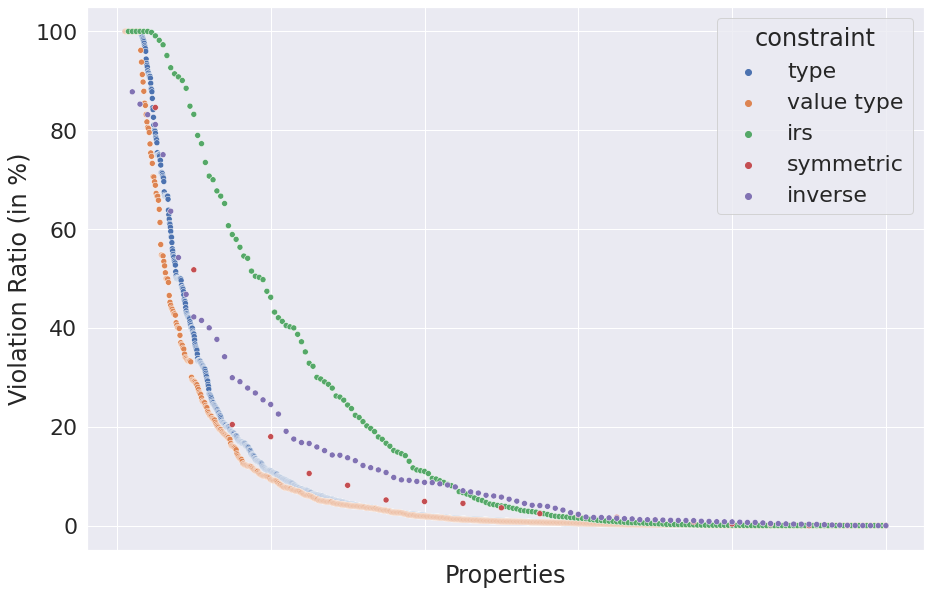

In [16]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=2)
ax = sns.scatterplot(x='index',y='VR',hue='constraint',data=constAnalysisDF)
ax.set(xlabel="Properties", ylabel = "Violation Ratio (in %)",xticklabels=[])
# h,l = ax.get_legend_handles_labels()
# plt.legend(h[0:3],l[0:3],bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0., fontsize=13)
# plt.show(ax)

# Analysis on properties with constraints

In [26]:
!kgtk --debug query -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz \
    ../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz \
    --match "p: (nodeProp1)-[nodePropEdge:P2302]->()" \
    -o ../../constraintsOP/claims.constraints_list.tsv \
    --graph-cache ../../sqlite3_caches/temp1345.valuetype.sqlite3.db

[2021-04-03 09:14:12 query]: SQL Translation:
---------------------------------------------
  SELECT *
     FROM graph_1 AS graph_1_c1
     WHERE graph_1_c1."label"=?
  PARAS: ['P2302']
---------------------------------------------


In [39]:
!kgtk unique -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz --column node1 -o ../../constraintsOP/claims.propList.tsv

In [42]:
!head ../../constraintsOP/claims.propList.tsv

node1	label	node2
P10	count	17
P1000	count	10
P1001	count	26
P1002	count	9
P1003	count	20
P1004	count	33
P1005	count	21
P1006	count	26
P1007	count	19


In [43]:
import pandas as pd
import os
props = pd.read_csv("../../constraintsOP/claims.constraints_list.tsv", sep='\t')

In [44]:
props2 = props.groupby(['node1']).node2.apply(list)

In [45]:
len(props2)

8100

In [48]:
cnt = 0
totalCnt = 0
for prop in props2.index:
    totalCnt += 1
    if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop +".tsv")):
        continue
    else:
        cnt += 1
cnt, totalCnt

(2336, 8100)

In [50]:
props2.head(500)

node1
P10      [Q21502404, Q21510851, Q21510852, Q52004125, Q...
P1000                    [Q21510856, Q21510865, Q53869507]
P1001         [Q21502838, Q21503250, Q21510865, Q25796498]
P1002                               [Q21503250, Q21510865]
P1003    [Q19474404, Q21502404, Q21502410, Q21510851, Q...
                               ...                        
P1563    [Q19474404, Q21502404, Q21502410, Q21503247, Q...
P1564    [Q19474404, Q21502404, Q21502410, Q21503247, Q...
P1565    [Q19474404, Q21502404, Q21502410, Q21503247, Q...
P1566    [Q19474404, Q21502404, Q21502410, Q21502838, Q...
P1567    [Q19474404, Q21502404, Q21502410, Q21502838, Q...
Name: node2, Length: 500, dtype: object

In [32]:
import pandas as pd
import os
props2 = pd.read_csv("../../constraintsOP/claims.propList.tsv", sep='\t')

In [33]:
props2 = props2.groupby(['node1']).node2.apply(list)

In [34]:
len(props2)

8193

In [35]:
cnt = 0
totalCnt = 0
for prop in props2.index:
    totalCnt += 1
    if not(os.path.isfile("../../propertiesSplit_Final/claims."+ prop +".tsv")):
        continue
    else:
        cnt += 1
cnt, totalCnt

(2415, 8193)

In [50]:
props2.head(500)

node1
P10      [Q21502404, Q21510851, Q21510852, Q52004125, Q...
P1000                    [Q21510856, Q21510865, Q53869507]
P1001         [Q21502838, Q21503250, Q21510865, Q25796498]
P1002                               [Q21503250, Q21510865]
P1003    [Q19474404, Q21502404, Q21502410, Q21510851, Q...
                               ...                        
P1563    [Q19474404, Q21502404, Q21502410, Q21503247, Q...
P1564    [Q19474404, Q21502404, Q21502410, Q21503247, Q...
P1565    [Q19474404, Q21502404, Q21502410, Q21503247, Q...
P1566    [Q19474404, Q21502404, Q21502410, Q21502838, Q...
P1567    [Q19474404, Q21502404, Q21502410, Q21502838, Q...
Name: node2, Length: 500, dtype: object